In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

In [2]:
from mendeleev import element
import pandas as pd
import seaborn as sns
import pymatgen.core as mg
import plotly.express as px
from matplotlib.colors import LogNorm, Normalize
import warnings
import pickle

# Getting Data

In [3]:
dt_old=pd.read_csv("mnse2_dat.csv")
dt=dt_old
dt["log_MA"]=np.log(dt["abs_MA"])
dt["MA"]=dt["abs_MA"]*dt["sign_MA"]

dtno_na=dt[~(dt["sign_MA"].isna()|dt["E_form SO-overall"].isna())]
dtno_na["OP mag_A1"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mag_A1"],dtno_na["AFM-SO mag_A1"])
dtno_na["OP mag_A2"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mag_A2"],dtno_na["AFM-SO mag_A2"])
dtno_na["IP mag_A1"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-IP-SO mag_A1"],dtno_na["AFM-IP-SO mag_A1"])
dtno_na["IP mag_A2"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-IP-SO mag_A2"],dtno_na["AFM-IP-SO mag_A2"])

dtno_na["OP mu_A1"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mu_A1"],dtno_na["AFM-SO mu_A1"])
dtno_na["OP mu_A2"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mu_A2"],dtno_na["AFM-SO mu_A2"])
dtno_na["IP mu_A1"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-IP-SO mu_A1"],dtno_na["AFM-IP-SO mu_A1"])
dtno_na["IP mu_A2"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-IP-SO mu_A2"],dtno_na["AFM-IP-SO mu_A2"])

thresh=0.01
dtno_na["is mag?"]=((dtno_na["OP mag_A1"]>thresh)&(dtno_na["IP mag_A1"]>thresh))|((dtno_na["OP mag_A2"]>thresh)&(dtno_na["IP mag_A2"]>thresh))
dt_magnet=dtno_na[dtno_na["is mag?"]]

cutoff=-12
dt_lma=dt_magnet[dt_magnet["EMA is good?"]][dt_magnet["log_MA"]>cutoff]

C:\Users\peter\AppData\Local\Temp\ipykernel_24000\573151275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtno_na["OP mag_A1"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mag_A1"],dtno_na["AFM-SO mag_A1"])
C:\Users\peter\AppData\Local\Temp\ipykernel_24000\573151275.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtno_na["OP mag_A2"]=np.where(dtno_na["Ground Spin State SO-overall"]=="FM",dtno_na["FM-SO mag_A2"],dtno_na["AFM-SO mag_A2"])
C:\Users\peter\AppData\Local\Temp\ip

In [4]:
bad_mats=['1T-Cr1Ru1Se4',
 '1T-Co1Pd1Se4',
 '1T-Co2Se4',
 '1T-Cr1Au1Te4',
 '1T-Cr1Nb1S4',
 '1T-Cr1Zn1Se4',
 '1T-Fe1Zn1Se4',
 '1T-Mn1Hf1Te4',
 '1T-Mn1Lu1Te4',
 '1T-Mn1Os1Se4',
 '1T-Mn1Re1S4',
 '1T-Mn1Re1Se4',
 '1T-Mn1Ru1Se4',
 '1T-V1Co1Te4',
 '1T-V1Hf1Te4',
 '1T-V1Hg1Te4',
 '1T-V1Os1S4',
 '1T-V1Pd1Te4',
 '1T-V1Zn1S4',
 '1T-V1Zn1Se4',
 '1T-Cr1Ru1S4',
 '1T-Mn1Re1Te4',
 '1T-Mn1Zn1Te4',
 '1T-V1Au1Te4',
 '1T-V1Ni1S4',
 '1T-V1Y1Te4',
 '1T-Co1Ni1S4',
 '1T-Co1W1Se4',
 '1T-Co2S4',
 '1T-Cr1Ir1S4',
 '1T-Fe1Cd1Se4',
 '1T-Fe1Re1Te4',
 '1T-Fe1W1Te4',
 '1T-Fe2Te4',
 '1T-Mn1Y1Te4',
 '1T-Mo1Y1Te4',
 '1T-Os1Nb1Se4',
 '1T-V1Fe1Te4',
 '1T-V1Hg1Se4',
 '1T-W1Tc1Te4']
corrections=[('1T-Co1Pd1S4', -0.000258519999999152),
 ('1T-Fe1Ta1Te4', 0.000144409999997208),
 ('1T-Mn1Os1S4',-0.000173339999999911),
 ('1T-V1Ag1Te4', -0.0000249149999991261),
 ('1T-V1Os1Se4',0.000126879999999829),
 ('1T-V1Pd1S4', -0.0000287849999978107),
 ('1T-V1Pt1S4', -0.000025905000001103)]

dt_corr=dt_lma[~dt_lma["Material"].isin(bad_mats)]
for m,corr_ma in corrections:
    m_ind=dt_corr[dt_corr["Material"]==m].index[0]
    dt_corr.loc[m_ind,"MA"]=corr_ma
    dt_corr.loc[m_ind,"log_MA"]=np.log(abs(corr_ma))
    dt_corr.loc[m_ind,"sign_MA"]=np.sign(corr_ma)


In [5]:
from pymatgen.core.structure import Structure, Element
from pymatgen.transformations.site_transformations import ReplaceSiteSpeciesTransformation

In [6]:
base_struct=Structure.from_file("1T-Mn1Cr1Te4.VASP")

def decorate_lattice(base_struct,A1,A2,X):
    new_struct=base_struct.copy()
    new_struct.replace_species({"Mn":A1,"Cr":A2,"Te":X})
    return new_struct

dt_corr["structure"]=dt_corr.apply(lambda x: decorate_lattice(base_struct,x.A1,x.A2,x.X),axis=1)
dt_corr["Composition"]=dt_corr["Material"].apply(lambda x: x.split("-")[1])

C:\Users\peter\AppData\Local\Temp\ipykernel_24000\3847078851.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_corr["structure"]=dt_corr.apply(lambda x: decorate_lattice(base_struct,x.A1,x.A2,x.X),axis=1)
C:\Users\peter\AppData\Local\Temp\ipykernel_24000\3847078851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_corr["Composition"]=dt_corr["Material"].apply(lambda x: x.split("-")[1])


# Feature Construction

In [7]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers.structure import SineCoulombMatrix
from matminer.featurizers.conversions import CompositionToOxidComposition
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition

In [8]:
data=dt_corr[["Material","A1","A2","X","structure","Composition","log_MA","sign_MA"]]

data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'Composition')
data = CompositionToOxidComposition().featurize_dataframe(data, "composition_obj")

# feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
#                                           cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
# feature_labels = feature_calculators.feature_labels()
# data = feature_calculators.featurize_dataframe(data, col_id='composition_oxid');

calc=cf.ElementProperty("magpie",features=['AtomicVolume','DipolePolarizability','FirstIonizationEnergy','ElectronAffinity','Electronegativity', 'NsValence', 'NpValence',
                          'NdValence', 'NfValence', 'NValence', 'NsUnfilled',
                          'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'Number',
                            'CovalentRadius'],stats=["flatten"])
feature_labels=calc.feature_labels()
data=calc.featurize_dataframe(data,col_id='composition_oxid')
features_used=[]

StrToComposition:   0%|          | 0/185 [00:00<?, ?it/s]

CompositionToOxidComposition:   0%|          | 0/185 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/185 [00:00<?, ?it/s]

In [9]:
features_used=[]

for f in feature_labels:
    
    feat_name=f.split()[-1]
    data[f"{feat_name} A1"]=data[f].apply(lambda x: x[0])
    data[f"{feat_name} A2"]=data[f].apply(lambda x: x[0] if len(x)==2 else x[1])
    data[f"{feat_name} X"]=data[f].apply(lambda x: x[-1])
    data[f"{feat_name} A_avg"]=(data[f"{feat_name} A1"]+data[f"{feat_name} A2"])/2
    data[f"{feat_name} A_diff"]=abs(data[f"{feat_name} A1"]-data[f"{feat_name} A2"])
    data[f"{feat_name} AX_diff_avg"]=(abs(data[f"{feat_name} A1"]-data[f"{feat_name} X"])+abs(data[f"{feat_name} A2"]-data[f"{feat_name} X"]))/2
    data[f"{feat_name} AX_diff_diff"]=abs(abs(data[f"{feat_name} A1"]-data[f"{feat_name} X"])-abs(data[f"{feat_name} A2"]-data[f"{feat_name} X"]))
    
    features_used+=[f"{feat_name} A_avg",f"{feat_name} A_diff",f"{feat_name} AX_diff_avg",f"{feat_name} AX_diff_diff",f"{feat_name} X"]

C:\Users\peter\AppData\Local\Temp\ipykernel_24000\2929932537.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{feat_name} A1"]=data[f].apply(lambda x: x[0])
C:\Users\peter\AppData\Local\Temp\ipykernel_24000\2929932537.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f"{feat_name} A2"]=data[f].apply(lambda x: x[0] if len(x)==2 else x[1])
C:\Users\peter\AppData\Local\Temp\ipykernel_24000\2929932537.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

In [10]:
def Nup(x,block):
    block_num={"s":1,"p":3,"d":5}[block]
    if x>block_num:
        return 2*block_num-x
    else:
        return x

data["Nup A1"]=data.apply(lambda x: Nup(x["NdValence A1"],"d")+Nup(x["NsValence A1"],"s"),axis=1)
data["Nup A2"]=data.apply(lambda x: Nup(x["NdValence A2"],"d")+Nup(x["NsValence A2"],"s"),axis=1)
data["Nup A_avg"]=(data["Nup A1"]+data["Nup A2"])/2
data["Nup A_diff"]=(data["Nup A1"]-data["Nup A2"])

features_used+=["Nup A_avg","Nup A_diff"]

In [11]:
def SOCC(el):
    socc={'Sc': 76,
      'Ti': 136,
     'V': 218,
     'Cr': 298,
     'Mn': 394,
     'Fe': 526,
     'Co': 94,
     'Ni': -736,
     'Cu': -952,
     'Zn': -1146,
     'Y': 304,
     'Zr': 481,
     'Nb': 688,
     'Mo': 901,
     'Tc': 1095,
     'Ru': 1496,
     'Rh': 364.5,
     'Pd': -1548,
     'Ag': -1915,
     'Cd': -2007,
     'Lu': 601,
     'Hf': 1974,
     'Ta': 2507,
     'W': 3209,
     'Re': 3634,
     'Os': 6718,
     'Ir': 2597,
     'Pt': -3711,
     'Au': -5583,
     'Hg': -6400
    }
    return socc[el]

data["SOCC A1"]=data.apply(lambda x: SOCC(x["A1"]), axis=1)
data["SOCC A2"]=data.apply(lambda x: SOCC(x["A2"]), axis=1)
data["SOCC A_diff"]=abs(data["SOCC A1"]-data["SOCC A2"])
data["SOCC A_avg"]=(data["SOCC A1"]+data["SOCC A2"])/2
features_used+=["SOCC A_diff","SOCC A_avg"]

In [12]:
cm=SineCoulombMatrix(flatten=True)
cm.fit(data["structure"])
features_used+=cm.feature_labels()
data=cm.featurize_dataframe(data,col_id="structure")

SineCoulombMatrix:   0%|          | 0/185 [00:00<?, ?it/s]

In [13]:
#remove highly correlated labels
X=data[features_used]

corr_tab=X.corr()

for feature in corr_tab:
    if all(np.isnan(corr_tab[feature])):
        features_used.remove(feature)
        print(feature)
        
X=data[features_used]


# used_features=features_used.copy()

# t=0.95
# for a,b in [(X.columns[i], X.columns[j]) for i,j in zip(*np.nonzero((abs(X.corr())>t).to_numpy())) if i<j]:
#     print(a,b)
#     if b in used_features:
#         used_features.remove(b)

# X=data[used_features]
# used_features

NsValence X
NpValence A_avg
NpValence A_diff
NpValence AX_diff_avg
NpValence AX_diff_diff
NpValence X
NfValence X
NsUnfilled X
NpUnfilled A_avg
NpUnfilled A_diff
NpUnfilled AX_diff_avg
NpUnfilled AX_diff_diff
NpUnfilled X
NdUnfilled X
NfUnfilled A_avg
NfUnfilled A_diff
NfUnfilled AX_diff_avg
NfUnfilled AX_diff_diff
NfUnfilled X


In [14]:
features_used

['AtomicVolume A_avg',
 'AtomicVolume A_diff',
 'AtomicVolume AX_diff_avg',
 'AtomicVolume AX_diff_diff',
 'AtomicVolume X',
 'DipolePolarizability A_avg',
 'DipolePolarizability A_diff',
 'DipolePolarizability AX_diff_avg',
 'DipolePolarizability AX_diff_diff',
 'DipolePolarizability X',
 'FirstIonizationEnergy A_avg',
 'FirstIonizationEnergy A_diff',
 'FirstIonizationEnergy AX_diff_avg',
 'FirstIonizationEnergy AX_diff_diff',
 'FirstIonizationEnergy X',
 'ElectronAffinity A_avg',
 'ElectronAffinity A_diff',
 'ElectronAffinity AX_diff_avg',
 'ElectronAffinity AX_diff_diff',
 'ElectronAffinity X',
 'Electronegativity A_avg',
 'Electronegativity A_diff',
 'Electronegativity AX_diff_avg',
 'Electronegativity AX_diff_diff',
 'Electronegativity X',
 'NsValence A_avg',
 'NsValence A_diff',
 'NsValence AX_diff_avg',
 'NsValence AX_diff_diff',
 'NdValence A_avg',
 'NdValence A_diff',
 'NdValence AX_diff_avg',
 'NdValence AX_diff_diff',
 'NdValence X',
 'NfValence A_avg',
 'NfValence A_diff',


In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

def hyper_param_search(model,param_grid,X_train,y_train,**kwargs):

    grid_clf = GridSearchCV(model, param_grid, **kwargs)
    grid_clf.fit(X_train, y_train)
    results_df=pd.DataFrame(grid_clf.cv_results_)
    results_df=pd.concat([results_df.drop(['params'], axis=1), pd.json_normalize(results_df['params'])], axis=1)
    return grid_clf,results_df

def train_and_eval_regressor(model_type,X_train,y_train,X_test,y_test,model_params={},cross_val_fold=7,do_print=True):
    model=model_type(**model_params)
    model.fit(X_train,y_train)

    y_predtrain=model.predict(X_train)
    train_r2=metrics.r2_score(y_train,y_predtrain)
    
    y_predt=model.predict(X_test)
    test_r2=metrics.r2_score(y_test,y_predt)
    
    if do_print:
        print(f"R^2 Train: {train_r2}")

        print(f"R^2 Val: {test_r2}")

        cv_scores=cross_val_score(model, X_train, y_train, cv=cross_val_fold, scoring='r2')
        print(f"{cross_val_fold}-fold cv: average R^2 = {cv_scores.mean()}, std = {cv_scores.std()}")

    return model,y_predt,y_predtrain,test_r2,train_r2

def regression_plot(y_test,y_predt,y_train,y_predtrain,pred_value="",xlimits=(-6,0),ylimits=(-6,0)):
    plt.scatter(y_test,y_predt,alpha=0.7,edgecolor='blue',label="test")
    plt.scatter(y_train,y_predtrain,alpha=0.7,edgecolor='orange',label="train")
    plt.plot(xlimits,ylimits)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    plt.xlabel(f"Calculated {pred_value}")
    plt.ylabel(f"Predictied {pred_value}")
    plt.legend()
    
def backwards_elim(model_type,X_train_set,y_train_set,X_val_set,y_val_set,hyper_param_grid,scoring='r2',
                   n_jobs=-1,model_params={},all_drops=[],is_classifier=False):
    """
    inputs:
    model_type - type of sklearn model
    X_train - training descriptors
    y_train - training labels
    X_val - validation descriptors
    y_val - validation labels
    model_params - hyperparameters
    all_drops - labels to be dropped in all cases
    
    outputs:
    (best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std)
    best_drop - list of descriptors dropped at each step
    best_score - mean score of the best descriptor set at each step
    best_std - std of score of the best descriptor set at each step
    best_set - final descriptor set at end of backwards elimination
    X_tr_star - training descriptors with best_set as the columns
    X_val_star - validation descriptors with best_set as the columns
    all_scores - score of each descriptor set
    labels_dropped - labels dropped in each substep
    all_scores_std - std of score of each descriptor set
    """
    T=len(X_train_set)
    
    all_drops=list(all_drops)
    all_val_means={}
    all_val_stds={}
    all_tr_means={}
    all_tr_stds={}
    best_drop=[]
    best_val_mean=[]
    best_val_std=[]
    best_tr_mean=[]
    best_tr_std=[]
#     best_param_list=[]
#     grid_clf_list=[]
#     grid_df_list=[]
    
    columns=X_train_set[0].columns
    print(columns)
    k=0
    while len(columns)-len(all_drops)>4:
        drops=[all_drops+[d] for d in [c for c in columns if c not in all_drops]]
        
#         X_drop_hp=X_train_set[-1].drop(drops[0],axis=1)
#         y_tr_hp=y_train_set[-1]
        
#         print(f"<<<testing hyperparameters>>>")
        
#         #do hyper_param_search for current set
#         clf=model_type()
#         grid_clf,grid_df=hyper_param_search(clf,hyper_param_grid,X_drop_hp,y_tr_hp,cv=7,verbose=10,n_jobs=n_jobs,scoring=scoring)
#         grid_clf_list.append(grid_clf)
#         grid_df_list.append(grid_df)
#         best_params=grid_clf.best_params_
#         best_param_list.append(best_params)
        
        cols_used=[tuple(set(columns)-set(drop)) for drop in drops]
        drop_labels=[]

        val_means=[]
        tr_means=[]
        val_stds=[]
        tr_stds=[]
        count=0
        
        for n,drop in enumerate(drops):
            count+=1
            print(f"testing {cols_used[n]} ({count}/{len(drops)}):",end="")
            v_r2s=np.zeros(T)
            tr_r2s=np.zeros(T)
    
            for i in range(T):
                X_drop=X_train_set[i].drop(drop,axis=1)
                X_val_drop=X_val_set[i].drop(drop,axis=1)
                y_cur=y_train_set[i]
                y_val_cur=y_val_set[i]
                
                print("+",end="")
                clf=model_type(**model_params)
                if is_classifier:
                    _,_,_,v_r2,t_r2=train_and_eval_classifier(model_type,X_drop,y_cur,X_val_drop,y_val_cur,model_params=model_params,do_print=False)
                else:
                    _,_,_,v_r2,t_r2=train_and_eval_regressor(model_type,X_drop,y_cur,X_val_drop,y_val_cur,model_params=model_params,do_print=False)
                v_r2s[i]=v_r2
                tr_r2s[i]=t_r2
    
            v_mean=np.mean(v_r2s)
            v_std=np.std(v_r2s)
            tr_mean=np.mean(tr_r2s)
            tr_std=np.std(tr_r2s)
            
            val_means.append(v_mean)
            val_stds.append(v_std)
            tr_means.append(tr_mean)
            tr_stds.append(tr_std)
            
            all_val_means[cols_used[n]]=v_mean
            all_val_stds[cols_used[n]]=v_std
            all_tr_means[cols_used[n]]=tr_mean
            all_tr_stds[cols_used[n]]=tr_std
            drop_labels.append(drop[-1])
            
            print()
            
        m_idx=np.argmax(val_means)
        best=drop_labels[m_idx]
        print(f"best result was dropping: {best} with val score {val_means[m_idx]}+-{val_stds[m_idx]/np.sqrt(T)} and training score {tr_means[m_idx]}+-{tr_stds[m_idx]/np.sqrt(T)}")
        all_drops.append(best)
        best_drop.append(best)
        best_val_mean.append(val_means[m_idx])
        best_val_std.append(val_stds[m_idx])
        best_tr_mean.append(tr_means[m_idx])
        best_tr_std.append(tr_stds[m_idx])
    
    best_ind=best_val_mean.index(max(best_val_mean))
    col_star=best_drop[best_ind+1:]
    
    print(col_star)
    drops_star=[c for c in columns if c not in col_star]

    return best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,col_star,drops_star,all_val_means,all_val_stds,all_tr_means,all_tr_stds


# log_MA ML

In [470]:
y=data["log_MA"]

from sklearn.model_selection import train_test_split

X_org, X_test, y_org, y_test = train_test_split(X, y, test_size=0.1,random_state=45)
X_torg, X_val, y_torg, y_val = train_test_split(X_org,y_org, test_size=0.1,random_state=46)
X_train,y_train=X_torg,y_torg

In [471]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

model_type=RandomForestRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': range(32,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,3,4],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf,grid_df=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params=grid_clf.best_params_

Fitting 7 folds for each of 2304 candidates, totalling 16128 fits


R^2 Train: 0.9093881381168608
R^2 Test: 0.1769320101069195
7-fold cv: average R^2 = 0.2331647127159451, std = 0.21024381329347303


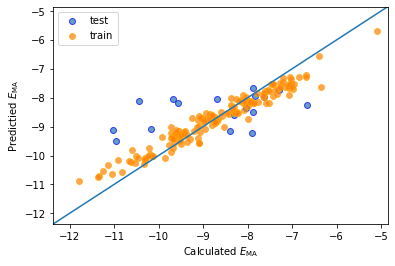

In [472]:
clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_val,y_val,model_params=best_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

In [473]:
N_sets=20

X_val_sets=[]
y_val_sets=[]
X_train_sets=[]
y_train_sets=[]

for i in range(N_sets):
    X_torg_n, X_val_n, y_torg_n, y_val_n = train_test_split(X_org,y_org, test_size=0.1)
    X_train_n,y_train_n=X_torg_n,y_torg_n
    X_train_sets.append(X_train_n)
    y_train_sets.append(y_train_n)
    X_val_sets.append(X_val_n)
    y_val_sets.append(y_val_n)

In [54]:
def calc_importances(model_type,X_train_sets,y_train_sets,model_params={},trial_N=1000,do_plot=True):
    importances=np.zeros((len(X_train_sets[0].T),trial_N))

    for i in range(len(X_train_sets)):
        if i%100==0:
            print(i)
        clf=model_type(**model_params)
        clf.fit(X_train_sets[i],y_train_sets[i])
        importances[:,i]=clf.feature_importances_
    
    import_means=np.mean(importances,axis=1)
    import_std=np.std(importances,axis=1)
    sorted_idx=import_means.argsort()
    if do_plot:
        #figure(figsize=(8, 6), dpi=80)
        plt.bar(X_train_sets[0].columns[sorted_idx],import_means[sorted_idx],yerr=import_std[sorted_idx]/len(X_train_sets))
    
    return importances,import_means,import_std

0


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

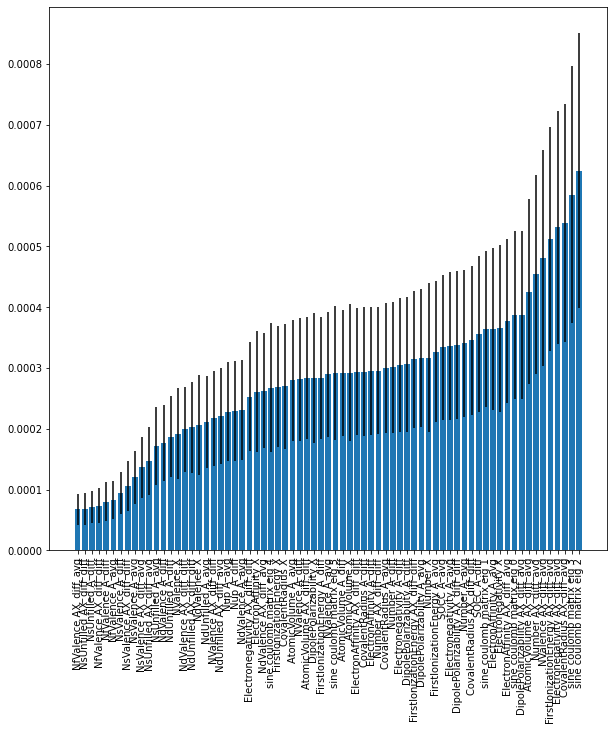

In [516]:
plt.figure(figsize=(10,10))
calc_importances(model_type,X_train_sets,y_train_sets,model_params=best_params)

plt.xticks(rotation=90)


In [476]:
best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std=backwards_elim(model_type,
                                                          X_train_sets,
                                                          y_train_sets,
                                                          X_val_sets,
                                                          y_val_sets,
                                                          param_grid,
                                                          scoring='r2',
                                                          model_params=best_params,
                                                          all_drops=[])

Index(['NsValence AX_diff_diff', 'sine coulomb matrix eig 0',
       'FirstIonizationEnergy A_diff', 'AtomicVolume AX_diff_avg',
       'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg',
       'Electronegativity A_avg', 'AtomicVolume A_diff',
       'ElectronAffinity A_avg', 'NfValence AX_diff_avg',
       'ElectronAffinity AX_diff_avg', 'NdValence A_diff',
       'NValence AX_diff_avg', 'NsUnfilled AX_diff_diff',
       'DipolePolarizability X', 'Electronegativity X',
       'DipolePolarizability AX_diff_avg', 'NdUnfilled AX_diff_avg',
       'NdUnfilled AX_diff_diff', 'SOCC A_avg', 'NValence X',
       'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff',
       'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg',
       'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg',
       'Nup A_avg', 'ElectronAffinity AX_diff_diff', 'NdValence AX_diff_avg',
       'Number A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff',
       'AtomicVolume AX_diff_diff'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'El

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'E

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electron

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'DipolePolarizability A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_

testing ('FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValen

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_di

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NVale

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValen

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'SOCC A_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'ElectronAffinity A_avg', 'NValence AX_d

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValenc

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity AX_diff_diff', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_av

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electr

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'Number A_diff', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electro

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativ

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'S

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'S

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'S

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativit

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'N

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'NdUnfilled AX_diff_diff', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X',

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativ

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValen

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'NfValence A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativ

testing ('FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff',

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence AX

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'ElectronAffinity A_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValen

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', '

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdU

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfill

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'Electronegativity A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_di

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence A

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NdUnfilled A_diff', 'NdVale

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfill

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfill

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'NdValence A_diff', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_dif

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_a

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfV

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence 

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'ElectronAffinity A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValen

testing ('FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'N

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValen

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg'

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg',

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdVa

testing ('NsValence AX_diff_diff', 'FirstIonizationEnergy A_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValen

testing ('NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'N

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValen

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValen

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'AtomicVolume A_diff', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_av

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_di

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Numbe

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Numbe

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Numbe

testing ('NsValence AX_diff_diff', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVo

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_diff

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVo

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_diff',

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Numbe

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 0', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_di

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolariza

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolariza

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'AtomicVolume AX_diff_diff', 'Dipol

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizabili

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_diff', 'ElectronAffinity AX_diff_avg', 'NdUnfilled AX_diff_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'Number AX_diff_avg', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_diff', 'sine coulomb matrix eig 1', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NValence AX_diff_avg', 'SOCC A_avg', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'AtomicVolume AX_di

testing ('AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_dif

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfille

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValen

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEn

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEn

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsVa

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValen

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfi

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsVa

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_d

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_d

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfi

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsVa

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValen

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'DipolePolarizability AX_diff_avg', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfi

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizabil

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff'

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizab

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_di

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'AtomicVolume A_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX

testing ('AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine co

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_dif

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulo

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsUnfilled A_diff', 'NsValence AX_diff_avg', 'DipolePolarizabili

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3',

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sin

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'si

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulo

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulo

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence AX_diff_diff', 'NdValence A_avg', 'NfValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb mat

testing ('AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NfValence A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NfValence A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfVale

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NfValence A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_dif

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NfValence A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Elec

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electro

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'SOCC A_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electr

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativit

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativ

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'NdValence AX_diff_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativit

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Num

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'NValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X',

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadiu

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'Covalent

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Nup A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_dif

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', '

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'si

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix ei

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'CovalentRadius X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (7/3

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (21/39):++

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'NsValence AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (11/38):++++++++++++++

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'NfValence AX_diff_diff', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (27/38):+++++++++++++++++++

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (5/37):++++++++++++++++++++
testing ('NsValence AX

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (21/37):++++++++++++++++++++
testing ('NsValence AX_diff_diff

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'Number AX_diff_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (37/37):++++++++++++++++++++
best resu

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (16/36):++++++++++++++++++++
testing ('NsValence AX_diff_diff', '

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NValence A_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (32/36):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolu

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (12/35):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_a

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'NdValence A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (28/35):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (9/34):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'FirstIonizationEnergy X', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (25/34):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'N

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (7/33):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegat

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NsUnfilled AX_diff_diff', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (25/33):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electron

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (10/32):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfVa

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'NValence AX_diff_diff', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (28/32):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValenc

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'CovalentRadius AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (14/31):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronA

testing ('AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (1/30):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electr

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'FirstIonizationEnergy A_avg', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (21/30):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'Dip

testing ('AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (1/29):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'CovalentRadius A_diff', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (21/29):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronega

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (12/28):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NsUnfilled A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_dif

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1', 'NdValence X') (4/27):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'Dipol

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdValence X') (26/27):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolu

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 2', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (21/26):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (17/25):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume AX_diff_diff', 'DipolePolarizability A_av

testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (15/24):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'AtomicVolume AX_diff_avg', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_dif

testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (15/23):++++++++++++++++++++
testing ('NsValence AX_diff_diff', 'NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity

testing ('NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (17/22):++++++++++++++++++++
testing ('NsValence A_avg', 'Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'DipolePolarizability A_avg', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'FirstIonizationEnergy AX_diff_avg', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_dif

testing ('Electronegativity A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'sine coulomb matrix eig 1') (1/20):++++++++++++++++++++
testing ('NsValence A_avg', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X', 'Electronegativity X', 'Number AX_diff_avg', 'NdUnfilled A_diff', 'AtomicVolume X', 'FirstIonizationEnergy AX_diff_diff', 'ElectronAffinity X', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'Electronegativity AX_diff_avg', 'Number X', 'Cov

testing ('DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'DipolePolarizability X', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NfValence AX_diff_avg', 'ElectronAffinity AX_diff_avg', 'Electronegativity X') (11/19):++++++++++++++++++++
testing ('DipolePolarizability AX_diff_diff', 'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4', 'DipolePolarizability X', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NfValence AX_diff_avg', 'sine coulomb matrix eig 5', 'ElectronAffinity AX_diff_avg', 'Electronegat

testing ('sine coulomb matrix eig 4', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NfValence AX_diff_avg', 'sine coulomb matrix eig 5', 'ElectronAffinity AX_diff_avg', 'DipolePolarizability X') (5/17):++++++++++++++++++++
testing ('sine coulomb matrix eig 4', 'DipolePolarizability X', 'Electronegativity AX_diff_avg', 'AtomicVolume X', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'NsUnfilled AX_diff_avg', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NfValence AX_diff_avg', 'sine coulomb matrix eig 5', 'ElectronAffinity AX_diff_avg', 'Electronegativity X') (6/17):++++++++++++++++++++
testing ('sine coulomb matrix eig 4', 'DipolePolarizability X', 'Number AX_diff_avg',

testing ('DipolePolarizability X', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NfValence AX_diff_avg', 'sine coulomb matrix eig 5', 'NsUnfilled AX_diff_avg', 'Electronegativity X') (8/15):++++++++++++++++++++
testing ('DipolePolarizability X', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'sine coulomb matrix eig 5', 'NfValence AX_diff_avg', 'NsUnfilled AX_diff_avg', 'Electronegativity X') (9/15):++++++++++++++++++++
testing ('DipolePolarizability X', 'Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'sine coulom

testing ('Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NsUnfilled AX_diff_avg', 'DipolePolarizability X') (10/12):++++++++++++++++++++
testing ('Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'sine coulomb matrix eig 1', 'Electronegativity A_avg', 'ElectronAffinity X', 'NsUnfilled AX_diff_avg', 'DipolePolarizability X') (11/12):++++++++++++++++++++
testing ('Number AX_diff_avg', 'AtomicVolume X', 'Electronegativity AX_diff_avg', 'Number X', 'CovalentRadius AX_diff_diff', 'NdUnfilled A_diff', 'FirstIonizationEnergy AX_diff_diff', 'Electronegativity A_avg', 'ElectronAffinity X', 'NsUnfilled AX_diff_avg', 'DipolePolarizability X') (12/12):++++++++++++++++++++
best result was dropping: CovalentRadius AX

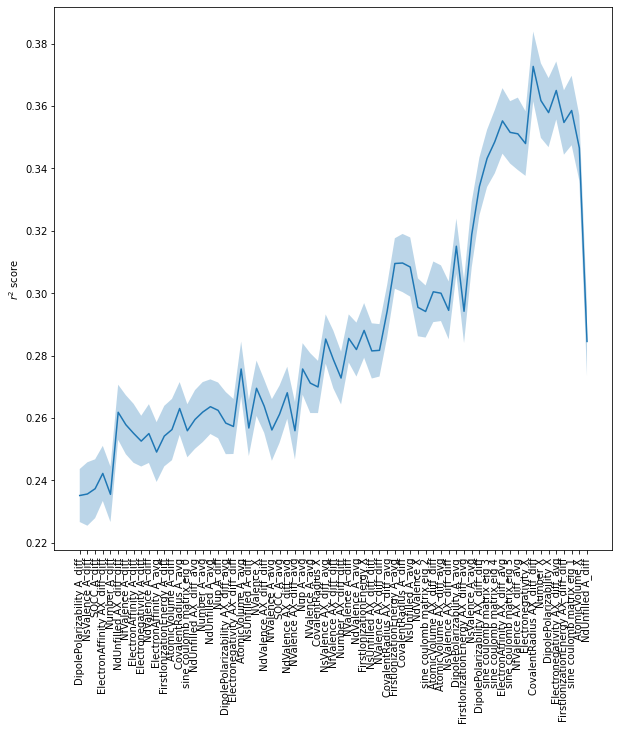

In [517]:
plt.figure(figsize=(10,10))

#plt.plot(best_drop,best_tr_mean)
#plt.fill_between(best_drop,np.array(best_tr_mean)-np.array(best_tr_std)/N_sets,np.array(best_tr_mean)+np.array(best_tr_std)/N_sets,alpha=0.3)
plt.plot(best_drop,best_val_mean)
plt.fill_between(best_drop,np.array(best_val_mean)-np.array(best_val_std)/N_sets,np.array(best_val_mean)+np.array(best_val_std)/N_sets,alpha=0.3)

plt.ylabel("$r^2$ score")

plt.xticks(rotation=90);

In [519]:
X_tr_star

Number AX_diff_avg  AtomicVolume X  Electronegativity AX_diff_avg  \
109                25.0       33.956689                          0.230   
237                27.0       33.956689                          0.550   
283                19.5       27.166546                          0.920   
363                29.0       33.956689                          0.470   
290                10.5       27.208805                          0.905   
..                  ...             ...                            ...   
361                 7.0       27.166546                          0.950   
314                 9.0       27.208805                          0.935   
70                 24.5       33.956689                          0.520   
209                11.0       27.208805                          1.095   
362                11.0       27.208805                          0.920   

     Number X  NdUnfilled A_diff  FirstIonizationEnergy AX_diff_diff  \
109      52.0                2.0                             0.26260   
237      52.0                0.0                             0.00000   
283      16.0                7.0                             2.24763   
363      52.0                0.0                             0.00000   
290      34.0                2.0                             0.02032   
..        ...                ...                                 ...   
361      16.0                0.0                             0.00000   
314      34.0                1.0                             0.01266   
70       52.0                2.0                             0.78306   
209      34.0                4.0                             0.87253   
362      34.0                0.0                             0.00000   

     sine coulomb matrix eig 1  Electronegativity A_avg  ElectronAffinity X  \
109                1446.912668                    1.870               190.2   
237                1122.633487                    1.550               190.2   
283                 953.850735                    1.660               200.0   
363                 920.280791                    1.630               190.2   
290                 981.677281                    1.645               195.0   
..                         ...                      ...                 ...   
361                 891.765448                    1.630               200.0   
314                3901.752183                    1.615               195.0   
70                  997.927802                    1.580               190.2   
209                 714.788891                    1.455               195.0   
362                 895.808004                    1.630               195.0   

     NsUnfilled AX_diff_avg  DipolePolarizability X  
109                     0.0                    5.50  
237                     0.0                    5.50  
283                     0.0                    2.90  
363                     0.0                    5.50  
290                     0.5                    3.77  
..                      ...                     ...  
361                     0.0                    2.90  
314                     0.5                    3.77  
70                      0.5                    5.50  
209                     0.0                    3.77  
362                     0.0                    3.77  

[149 rows x 11 columns]

In [493]:
best_cols=max(all_val_mean,key=all_val_mean.get)
X_tr_star=X_train[list(best_cols)]
X_val_star=X_val[list(best_cols)]
X_tr_star_sets=[x[list(best_cols)] for x in X_train_sets]
X_val_star_sets=[x[list(best_cols)] for x in X_val_sets]
best_cols

('Number AX_diff_avg',
 'AtomicVolume X',
 'Electronegativity AX_diff_avg',
 'Number X',
 'NdUnfilled A_diff',
 'FirstIonizationEnergy AX_diff_diff',
 'sine coulomb matrix eig 1',
 'Electronegativity A_avg',
 'ElectronAffinity X',
 'NsUnfilled AX_diff_avg',
 'DipolePolarizability X')

In [520]:
X_tr_star_sets[-2]

Number AX_diff_avg  AtomicVolume X  Electronegativity AX_diff_avg  \
59                 27.0       27.208805                          0.580   
164                 7.0       27.208805                          0.825   
335                10.5       27.208805                          0.635   
323                11.5       27.208805                          0.635   
175                35.0       27.166546                          0.705   
..                  ...             ...                            ...   
76                 25.0       27.208805                          0.540   
208                 7.0       27.166546                          1.125   
165                25.0       33.956689                          0.375   
198                26.5       33.956689                          0.365   
183                18.5       33.956689                          0.305   

     Number X  NdUnfilled A_diff  FirstIonizationEnergy AX_diff_diff  \
59       34.0                4.0                             2.19229   
164      34.0                5.0                             0.29236   
335      34.0                4.0                             0.61431   
323      34.0                7.0                             1.59071   
175      16.0                2.0                             1.53300   
..        ...                ...                                 ...   
76       34.0                1.0                             1.09752   
208      16.0                4.0                             0.87253   
165      52.0                5.0                             0.29236   
198      52.0                4.0                             1.52478   
183      52.0                0.0                             0.34159   

     sine coulomb matrix eig 1  Electronegativity A_avg  ElectronAffinity X  \
59                  981.084599                    1.970               195.0   
164                2831.777736                    1.725               195.0   
335                 887.315467                    1.915               195.0   
323                 887.319034                    1.915               195.0   
175                1155.656401                    1.875               200.0   
..                         ...                      ...                 ...   
76                  981.083417                    2.010               195.0   
208                 770.042521                    1.455               200.0   
165                1572.227063                    1.725               190.2   
198                1100.662481                    1.915               190.2   
183                3774.986540                    1.855               190.2   

     NsUnfilled AX_diff_avg  DipolePolarizability X  
59                      1.0                    3.77  
164                     0.5                    3.77  
335                     0.5                    3.77  
323                     0.0                    3.77  
175                     0.0                    2.90  
..                      ...                     ...  
76                      0.5                    3.77  
208                     0.0                    2.90  
165                     0.5                    5.50  
198                     0.5                    5.50  
183                     0.5                    5.50  

[149 rows x 11 columns]

In [529]:


X_ov_star=X_org[list(best_cols)]
y_ov=y_org

param_grid = {
                 'n_estimators': range(7,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[2,3,4,6,8,1.0],
                 'min_samples_split':[2, 5, 10, 15],
                'min_samples_leaf':[1, 2, 4, 6, 8, 10]
             }


#clf=model_type()

clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf,grid_df=hyper_param_search(clf,param_grid,X_ov_star,y_ov,cv=7,verbose=10,n_jobs=-1)
best_params_star_=grid_clf.best_params_
best_params_star_

Fitting 7 folds for each of 14976 candidates, totalling 104832 fits


{'max_depth': 16,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 57}

In [553]:
grid_df["max_features"]=grid_df["max_features"].apply(lambda x: x if x!=1 else 11)

In [531]:
param_grid2 = {
                 'n_estimators': range(7,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1],
                 'min_samples_split':[2, 5, 10, 15],
                'min_samples_leaf':[1, 2, 4, 6, 8, 10]
             }


#clf=model_type()

clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf2,grid_df2=hyper_param_search(clf,param_grid2,X_ov_star,y_ov,cv=7,verbose=10,n_jobs=-1)
best_params_star_2=grid_clf2.best_params_
best_params_star_2

Fitting 7 folds for each of 2496 candidates, totalling 17472 fits


{'max_depth': 14,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 42}

In [548]:
grid_df2.loc[grid_df2["mean_test_score"].idxmax()]

mean_fit_time              0.127089
std_fit_time               0.004159
mean_score_time            0.012111
std_score_time             0.001122
param_max_depth                  14
param_max_features                1
param_min_samples_leaf            2
param_min_samples_split           2
param_n_estimators               42
split0_test_score          0.426922
split1_test_score           0.41467
split2_test_score          0.244278
split3_test_score          0.420359
split4_test_score          0.394226
split5_test_score          0.163955
split6_test_score          0.288568
mean_test_score             0.33614
std_test_score             0.096529
rank_test_score                   1
max_depth                        14
max_features                      1
min_samples_leaf                  2
min_samples_split                 2
n_estimators                     42
Name: 1931, dtype: object

In [554]:
full_grid_df=pd.concat([grid_df,grid_df2])
full_grid_df["mean_test_score"].idxmax()

1931

In [ ]:
grid_ho_scores.xs(tuple(best_params_star_[x] for x in others),level=others)

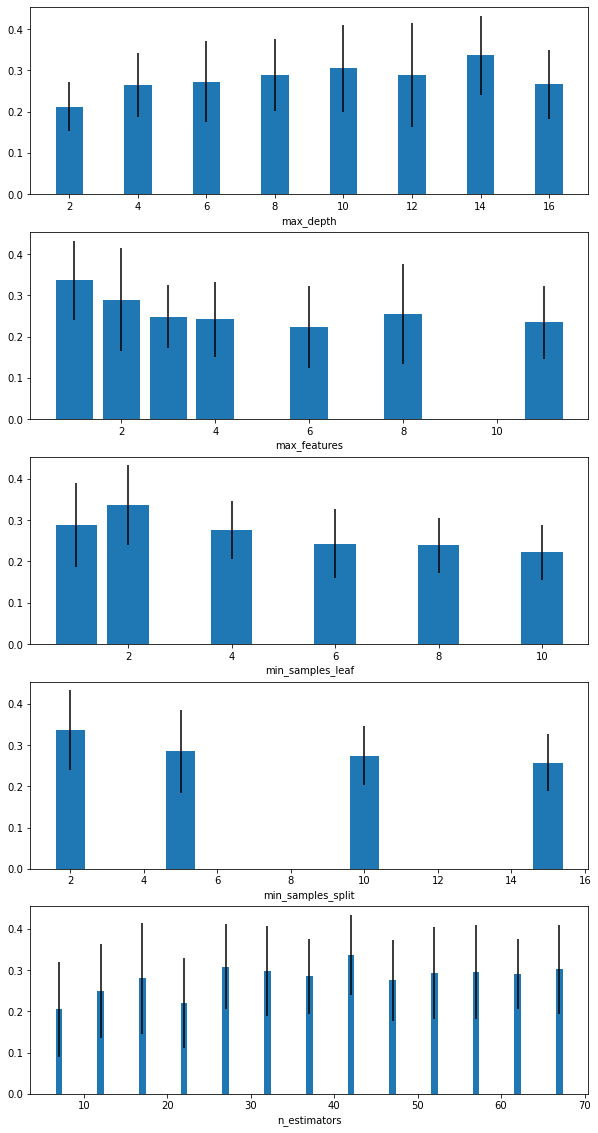

In [556]:
plt.figure(figsize=(10,20))
grid_ho_scores=full_grid_df.set_index(list(best_params_star_2))
for i,p in enumerate(best_params_star_2):
    ax=plt.subplot(len(best_params_star_2),1,i+1)
    others=[x for x in best_params_star_2 if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params_star_2[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

R^2 Train: 0.7314054493696502
R^2 Test: 0.26458079037539217
7-fold cv: average R^2 = 0.2514679326098721, std = 0.200877077343876


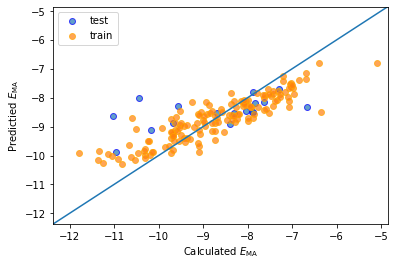

In [559]:
bp2=dict(best_params_star_2)
#bp2["n_estimators"]=200

clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_tr_star,y_train,X_val_star,y_val,model_params=bp2)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

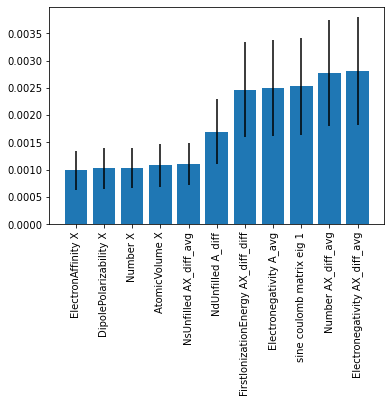

In [523]:
calc_importances(model_type,X_tr_star_sets,y_train_sets,model_params=bp2)
plt.xticks(rotation=90)

In [499]:
old_dt=pd.read_csv("MA_data.csv")

In [514]:
old_dt.filter(like="SOCC")

A1_SOCC  A2_SOCC  Abar_SOCC  dA_SOCC
0         94   1548.0      821.0  -1454.0
1        298   1915.0     1106.5  -1617.0
2        298   5583.0     2940.5  -5285.0
3        298   5583.0     2940.5  -5285.0
4        298   2007.0     1152.5  -1709.0
..       ...      ...        ...      ...
180      218    481.0      349.5   -263.0
181      218    481.0      349.5   -263.0
182      218    218.0      218.0      0.0
183      218    218.0      218.0      0.0
184      218    218.0      218.0      0.0

[185 rows x 4 columns]

# Combining DataSets

In [27]:
X_old=old_dt[['A1_rad', 'A2_rad',
       'X_rad', 'Abar_rad', 'dA_rad', 'Abar-X_rad', 'dAXbar_rad', 'ddAX_rad',
       'A1_dipole', 'A2_dipole', 'X_dipole', 'Abar_dipole', 'dA_dipole',
       'Abar-X_dipole', 'dAXbar_dipole', 'ddAX_dipole', 'A1_nvalence',
       'A2_nvalence', 'X_nvalence', 'Abar_nvalence', 'dA_nvalence',
       'Abar-X_nvalence', 'dAXbar_nvalence', 'ddAX_nvalence', 'A1_nup',
       'A2_nup', 'X_nup', 'Abar_nup', 'dA_nup', 'Abar-X_nup', 'dAXbar_nup',
       'ddAX_nup', 'A1_num_d', 'A2_num_d', 'X_num_d', 'Abar_num_d', 'dA_num_d',
       'Abar-X_num_d', 'dAXbar_num_d', 'ddAX_num_d', 'A1_volume', 'A2_volume',
       'X_volume', 'Abar_volume', 'dA_volume', 'Abar-X_volume',
       'dAXbar_volume', 'ddAX_volume', 'A1_ion_energy', 'A2_ion_energy',
       'X_ion_energy', 'Abar_ion_energy', 'dA_ion_energy', 'Abar-X_ion_energy',
       'dAXbar_ion_energy', 'ddAX_ion_energy', 'A1_electron_affinity',
       'A2_electron_affinity', 'X_electron_affinity', 'Abar_electron_affinity',
       'dA_electron_affinity', 'Abar-X_electron_affinity',
       'dAXbar_electron_affinity', 'ddAX_electron_affinity',
       'A1_electronegativity', 'A2_electronegativity', 'X_electronegativity',
       'Abar_electronegativity', 'dA_electronegativity',
       'Abar-X_electronegativity', 'dAXbar_electronegativity',
       'ddAX_electronegativity', 'A1_SOCC', 'A2_SOCC', 'Abar_SOCC', 'dA_SOCC']]

NameError: name 'old_dt' is not defined

In [ ]:

X_comb=pd.concat([X.reset_index(), X_old], axis = 1)
X_comb=X_comb.drop("index",axis=1)
X_comb["AXsumbar_rad"]=(X_comb["A1_rad"]+X_comb["A2_rad"])/2+X_comb["X_rad"]

In [ ]:
corr_tab=X_comb.corr()

for feature in corr_tab:
    if all(np.isnan(corr_tab[feature])):
        print(feature)

In [668]:
t=0.99
remove={'A1_SOCC','X_nvalence',
'X_nup',
 'A1_dipole',
 'A1_electron_affinity',
 'A1_electronegativity',
 'A1_ion_energy',
 'A1_num_d',
 'A1_nup',
 'A1_nvalence',
 'A1_rad',
 'A1_volume',
 'A2_SOCC',
 'A2_dipole',
 'A2_electron_affinity',
 'A2_electronegativity',
 'A2_ion_energy',
 'A2_num_d',
 'A2_nup',
 'A2_nvalence',
 'A2_rad',
 'A2_volume',
 'Abar-X_dipole',
 'Abar-X_electron_affinity',
 'Abar-X_electronegativity',
 'Abar-X_rad',
 'Abar_electron_affinity',
 'Abar_num_d',
 'AtomicVolume AX_diff_avg',
 'AtomicVolume AX_diff_diff',
 'AtomicVolume A_avg',
 'AtomicVolume A_diff',
 'AtomicVolume X',
 'CovalentRadius AX_diff_diff',
 'CovalentRadius A_avg',
 'CovalentRadius X',
 'DipolePolarizability AX_diff_avg',
 'DipolePolarizability AX_diff_diff',
 'DipolePolarizability A_avg',
 'DipolePolarizability X',
 'ElectronAffinity AX_diff_avg',
 'ElectronAffinity AX_diff_diff',
 'ElectronAffinity A_avg',
 'ElectronAffinity A_diff',
 'ElectronAffinity X',
 'Electronegativity X',
 'FirstIonizationEnergy AX_diff_avg',
 'FirstIonizationEnergy AX_diff_diff',
 'FirstIonizationEnergy A_avg',
 'FirstIonizationEnergy A_diff',
 'FirstIonizationEnergy X',
 'NdUnfilled AX_diff_avg',
 'NdUnfilled AX_diff_diff',
 'NdUnfilled A_avg',
 'NdUnfilled A_diff',
 'NdValence AX_diff_diff',
 'NdValence A_avg',
 'NdValence X',
 'NfValence AX_diff_avg',
 'NfValence AX_diff_diff',
 'NfValence A_diff',
 'NsUnfilled AX_diff_avg',
 'NsUnfilled AX_diff_diff',
 'NsValence AX_diff_avg',
 'NsValence AX_diff_diff',
 'SOCC A_avg',
 'SOCC A_diff',
 'X_electron_affinity',
 'X_electronegativity',
 'X_ion_energy',
 'X_num_d',
 'X_rad',
 'dAXbar_electron_affinity',
 'dA_electron_affinity',
 'dA_num_d',
 'ddAX_dipole',
 'ddAX_electron_affinity'}

for a,b in [(X_comb.columns[i], X_comb.columns[j]) for i,j in zip(*np.nonzero((abs(X_comb.corr())>t).to_numpy())) if i<j]:
    if not (a in remove or b in remove):
        print(f"Found correlation: {a} , {b}")
#         if choice=='a':
#             remove.add(a)
#         elif choice=='b':
#             remove.add(b)
#print(remove)

Found correlation: Number A_avg , Number A_diff
Found correlation: Number X , X_dipole
Found correlation: sine coulomb matrix eig 3 , sine coulomb matrix eig 4
Found correlation: sine coulomb matrix eig 3 , sine coulomb matrix eig 5
Found correlation: sine coulomb matrix eig 3 , X_volume
Found correlation: sine coulomb matrix eig 4 , sine coulomb matrix eig 5
Found correlation: sine coulomb matrix eig 4 , X_volume
Found correlation: sine coulomb matrix eig 5 , X_volume
Found correlation: Abar_SOCC , dA_SOCC


In [669]:
X_all=X_comb.drop(list(remove),axis=1)

In [670]:
y=data["log_MA"]

from sklearn.model_selection import train_test_split

X_org, X_test, y_org, y_test = train_test_split(X_all, y, test_size=0.1,random_state=45)
X_torg, X_val, y_torg, y_val = train_test_split(X_org,y_org, test_size=0.1,random_state=46)
X_train,y_train=X_torg,y_torg

In [671]:
N_sets=20

X_val_sets=[]
y_val_sets=[]
X_train_sets=[]
y_train_sets=[]

for i in range(N_sets):
    X_torg_n, X_val_n, y_torg_n, y_val_n = train_test_split(X_org,y_org, test_size=0.1)
    X_train_n,y_train_n=X_torg_n,y_torg_n
    X_train_sets.append(X_train_n)
    y_train_sets.append(y_train_n)
    X_val_sets.append(X_val_n)
    y_val_sets.append(y_val_n)

In [657]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

model_type=RandomForestRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': range(32,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,4,6,8,10],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf,grid_df=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params=grid_clf.best_params_

Fitting 7 folds for each of 3456 candidates, totalling 24192 fits


In [659]:
best_params

{'max_depth': 16,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 37}

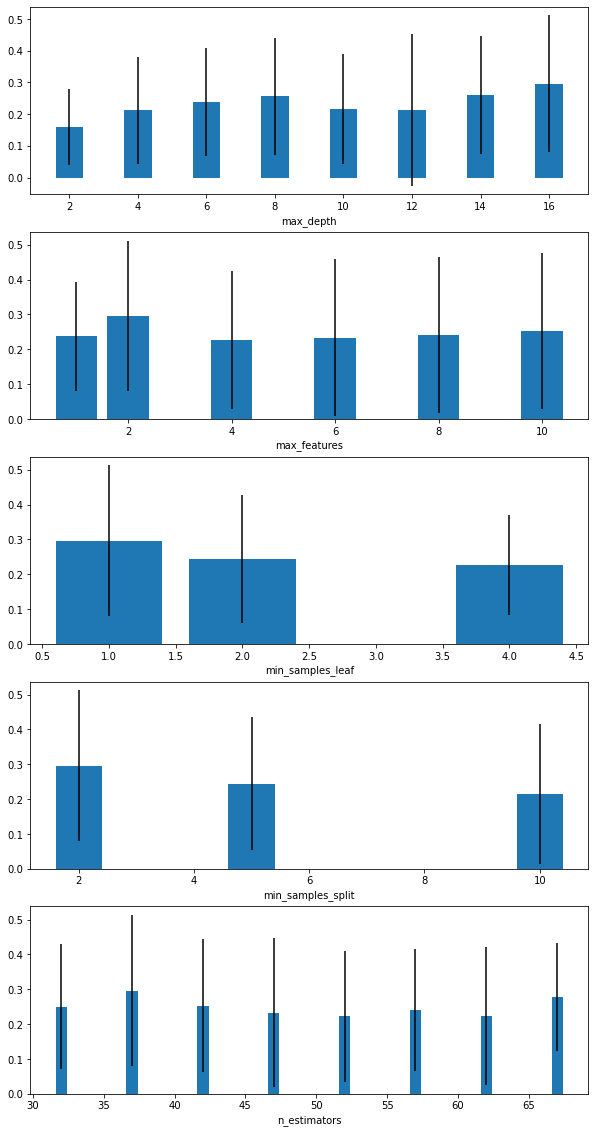

In [660]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df.set_index(list(best_params))
for i,p in enumerate(best_params):
    ax=plt.subplot(len(best_params),1,i+1)
    others=[x for x in best_params if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

R^2 Train: 0.9010329325291356
R^2 Test: 0.11956015011509558
7-fold cv: average R^2 = 0.22232183754761956, std = 0.21853683707850297


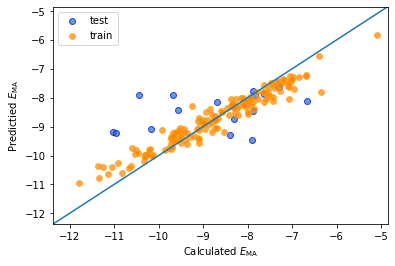

In [674]:
clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_val,y_val,model_params=best_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

In [675]:
X_train_t=X_train

0


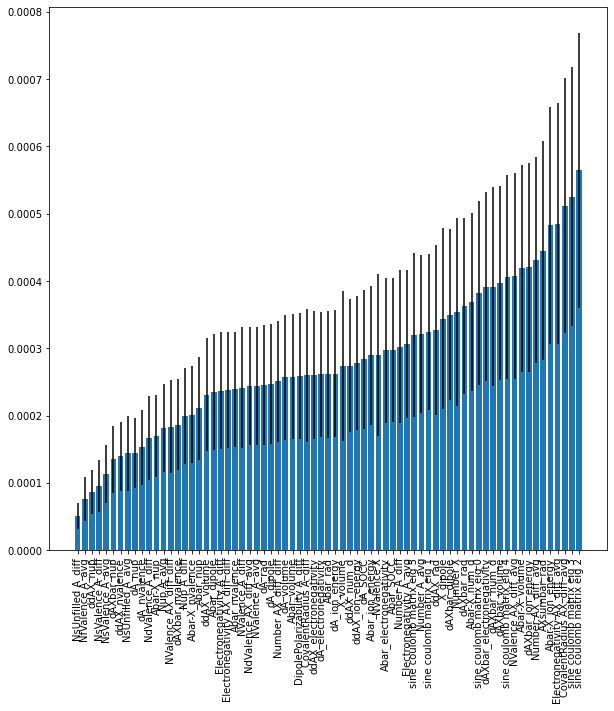

In [673]:
plt.figure(figsize=(10,10));
importances,import_means,import_std=calc_importances(model_type,X_tr_cur_sets,y_train_sets,model_params=best_params);

plt.xticks(rotation=90);


In [683]:
cur_columns=X_train.columns
cur_cols=cur_columns[import_means.argsort()][10:]
X_tr_cur=X_train[list(cur_cols)]
X_val_cur=X_val[list(cur_cols)]
X_tr_cur_sets=[x[list(cur_cols)] for x in X_train_sets]
X_val_cur_sets=[x[list(cur_cols)] for x in X_val_sets]

R^2 Train: 0.8968032753995653
R^2 Test: 0.1490597859512225
7-fold cv: average R^2 = 0.24400625650703314, std = 0.18364017680374886


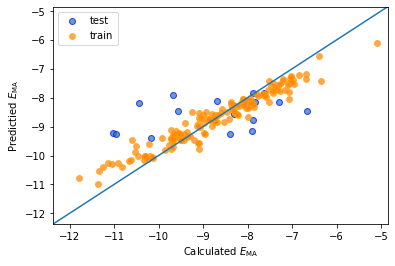

In [687]:
clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_tr_cur,y_train,X_val_cur,y_val,model_params=best_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

0


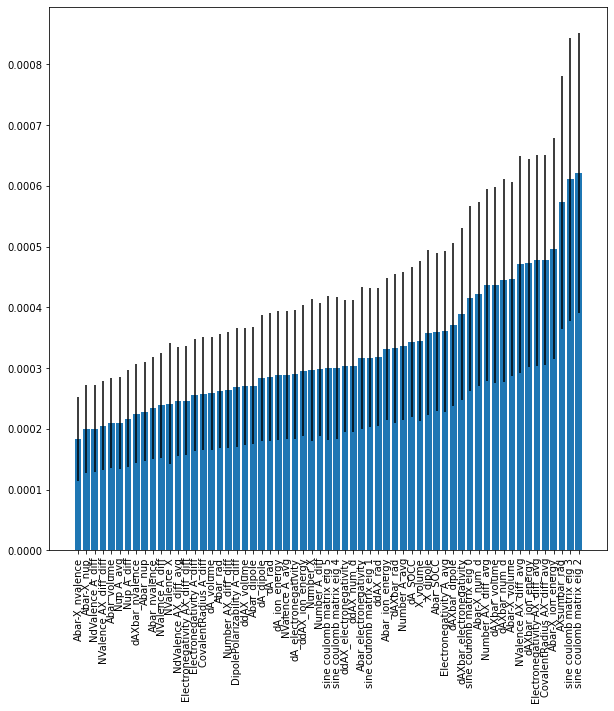

In [688]:
plt.figure(figsize=(10,10));
importances,import_means,import_std=calc_importances(model_type,X_tr_cur_sets,y_train_sets,model_params=best_params);

plt.xticks(rotation=90);

In [715]:
cur_columns=X_tr_cur.columns
cur_cols=cur_columns[import_means.argsort()][5:]
X_tr_cur=X_train[list(cur_cols)]
X_val_cur=X_val[list(cur_cols)]
X_tr_cur_sets=[x[list(cur_cols)] for x in X_train_sets]
X_val_cur_sets=[x[list(cur_cols)] for x in X_val_sets]

R^2 Train: 0.7361131243818639
R^2 Test: 0.1240739896054297
7-fold cv: average R^2 = 0.2549577841907914, std = 0.17404829092796795


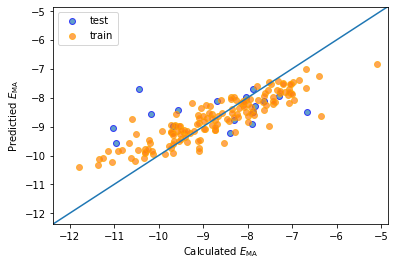

In [804]:
clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_tr_cur,y_train,X_val_cur,y_val,model_params=best_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

0


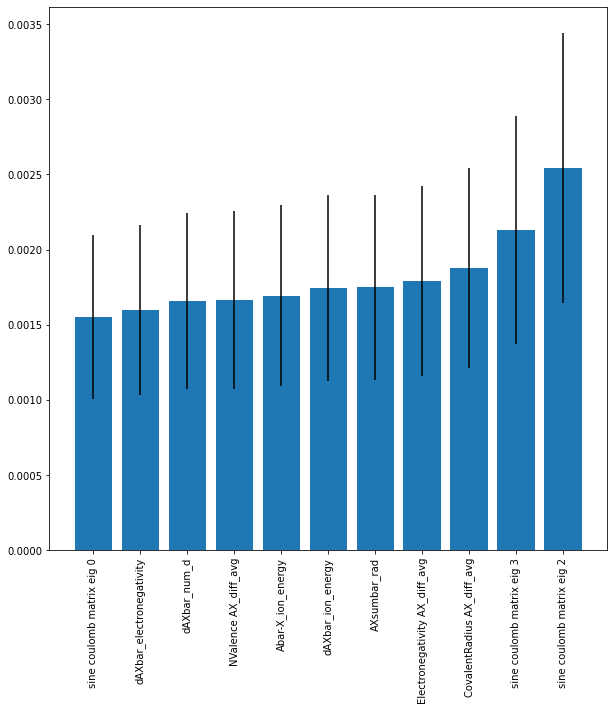

In [717]:
plt.figure(figsize=(10,10));
importances,import_means,import_std=calc_importances(model_type,X_tr_cur_sets,y_train_sets,model_params=best_params);

plt.xticks(rotation=90);

In [750]:
X_comb.filter(like="coulomb").columns

Index(['sine coulomb matrix eig 0', 'sine coulomb matrix eig 1',
       'sine coulomb matrix eig 2', 'sine coulomb matrix eig 3',
       'sine coulomb matrix eig 4', 'sine coulomb matrix eig 5'],
      dtype='object')

In [784]:
X_trial=X_comb[["NValence AX_diff_avg","Nup A_avg","X_volume","X_dipole","X_ion_energy","ddAX_electronegativity","SOCC A_diff","SOCC A_avg","dA_dipole","dAXbar_dipole","dAXbar_electronegativity","AXsumbar_rad",]]

In [785]:
y=data["log_MA"]

from sklearn.model_selection import train_test_split

X_org, X_test, y_org, y_test = train_test_split(X_trial, y, test_size=0.1,random_state=45)
X_torg, X_val, y_torg, y_val = train_test_split(X_org,y_org, test_size=0.1,random_state=46)
X_train,y_train=X_torg,y_torg

In [786]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

model_type=RandomForestRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': range(32,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,4,6,8,10],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf,grid_df=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params=grid_clf.best_params_

Fitting 7 folds for each of 3456 candidates, totalling 24192 fits


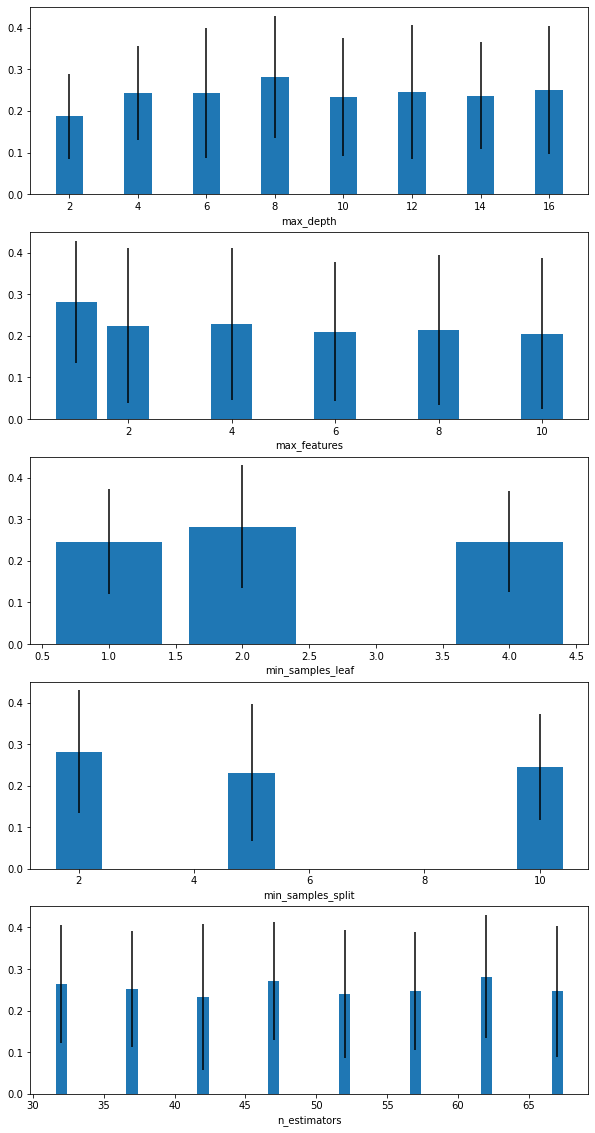

In [787]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df.set_index(list(best_params))
for i,p in enumerate(best_params):
    ax=plt.subplot(len(best_params),1,i+1)
    others=[x for x in best_params if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

In [790]:
best_params

{'max_depth': 8,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 62}

R^2 Train: 0.6993867060081427
R^2 Test: 0.11242560125433809
7-fold cv: average R^2 = 0.26934618765290597, std = 0.13190707180576836


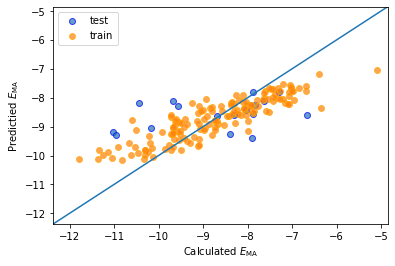

In [817]:
test_params=dict(best_params)
test_params["oob_score"]=False
test_params["max_samples"]

clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_val,y_val,model_params=test_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

In [1]:
import pickle
pickle

<module 'pickle' from 'C:\\ProgramData\\Anaconda3\\lib\\pickle.py'>

In [66]:
file = open("logma_clf-12-12.pkl",'rb')
(best_drop_logma,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star_logma,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std,\
best_param_list,grid_clf_list,grid_df_list,logma_clf,X_train,X_val,logma_X_tr_star,logma_y_train,logma_X_val_star,logma_y_val,logma_X_test,logma_y_test) = pickle.load(file)

In [67]:
def col_to_sym(descriptor):
    prop_map={"rad":r"r",
             "dipole":r"\alpha",
             "SOCC":r"\lambda",
             "nvalence":"N",
             "ion_energy":"I",
             "electron_affinity":"A",
             "electronegativity":r"\chi",
            "nup":"u",
            "num_d":"d",
            "volume":"V"}
    
    sym="?????????"
    
    site,prop=descriptor.split("_",1)
    
    if site=="dA":
        sym=f"$\\Delta {prop_map[prop]}_{{A}}$"
    elif site=="X":
        sym=f"${prop_map[prop]}_{{X}}$"
    elif site=="Abar":
        sym=f"$\\overline{{{prop_map[prop]}}}_{{A}}$"
    elif site=="dAXbar":
        sym=f"$\\overline{{\\Delta {prop_map[prop]}}}_{{A,X}}$"
    elif site=="ddAX":
        sym=f"$\\delta {prop_map[prop]}_{{A,X}}$"
    elif site=="Abar-X":
        sym=f"$\\Delta {prop_map[prop]}_{{A,X}}$"
    else:
        print(f"i dont know what {site} means!")
    
    return sym

In [64]:
[col_to_sym(p) for p in best_drop_logma]

['$\\overline{\\Delta I}_{A,X}$',
 '$\\overline{r}_{A}$',
 '$\\Delta \\chi_{A}$',
 '$\\overline{\\Delta u}_{A,X}$',
 '$\\delta r_{A,X}$',
 '$\\delta \\chi_{A,X}$',
 '$\\Delta A_{A}$',
 '$A_{X}$',
 '$\\Delta \\alpha_{A}$',
 '$\\delta V_{A,X}$',
 '$\\delta \\alpha_{A,X}$',
 '$\\Delta V_{A}$',
 '$\\overline{\\Delta \\chi}_{A,X}$',
 '$\\overline{\\Delta V}_{A,X}$',
 '$\\overline{\\chi}_{A}$',
 '$\\overline{\\Delta \\alpha}_{A,X}$',
 '$\\Delta u_{A,X}$',
 '$\\overline{\\Delta r}_{A,X}$',
 '$\\Delta N_{A,X}$',
 '$\\chi_{X}$',
 '$\\delta N_{A,X}$',
 '$u_{X}$',
 '$\\overline{d}_{A}$',
 '$\\Delta I_{A,X}$',
 '$\\overline{\\alpha}_{A}$',
 '$\\Delta r_{A,X}$',
 '$\\overline{\\Delta d}_{A,X}$',
 '$\\overline{N}_{A}$',
 '$\\overline{I}_{A}$',
 '$\\overline{V}_{A}$',
 '$\\overline{A}_{A}$',
 '$\\Delta N_{A}$',
 '$\\delta u_{A,X}$',
 '$\\Delta r_{A}$',
 '$\\delta d_{A,X}$',
 '$\\Delta V_{A,X}$',
 '$\\Delta \\alpha_{A,X}$',
 '$\\Delta \\chi_{A,X}$',
 '$\\Delta I_{A}$',
 '$\\Delta u_{A}$',
 '$\\delta I

['$\\overline{\\Delta I}_{A,X}$', '$\\overline{r}_{A}$', '$\\Delta \\chi_{A}$', '$\\overline{\\Delta u}_{A,X}$', '$\\delta r_{A,X}$', '$\\delta \\chi_{A,X}$', '$\\Delta A_{A}$', '$A_{X}$', '$\\Delta \\alpha_{A}$', '$\\delta V_{A,X}$', '$\\delta \\alpha_{A,X}$', '$\\Delta V_{A}$', '$\\overline{\\Delta \\chi}_{A,X}$', '$\\overline{\\Delta V}_{A,X}$', '$\\overline{\\chi}_{A}$', '$\\overline{\\Delta \\alpha}_{A,X}$', '$\\Delta u_{A,X}$', '$\\overline{\\Delta r}_{A,X}$', '$\\Delta N_{A,X}$', '$\\chi_{X}$', '$\\delta N_{A,X}$', '$u_{X}$', '$\\overline{d}_{A}$', '$\\Delta I_{A,X}$', '$\\overline{\\alpha}_{A}$', '$\\Delta r_{A,X}$', '$\\overline{\\Delta d}_{A,X}$', '$\\overline{N}_{A}$', '$\\overline{I}_{A}$', '$\\overline{V}_{A}$', '$\\overline{A}_{A}$', '$\\Delta N_{A}$', '$\\delta u_{A,X}$', '$\\Delta r_{A}$', '$\\delta d_{A,X}$', '$\\Delta V_{A,X}$', '$\\Delta \\alpha_{A,X}$', '$\\Delta \\chi_{A,X}$', '$\\Delta I_{A}$', '$\\Delta u_{A}$', '$\\delta I_{A,X}$', '$\\Delta A_{A,X}$', '$\\Delta

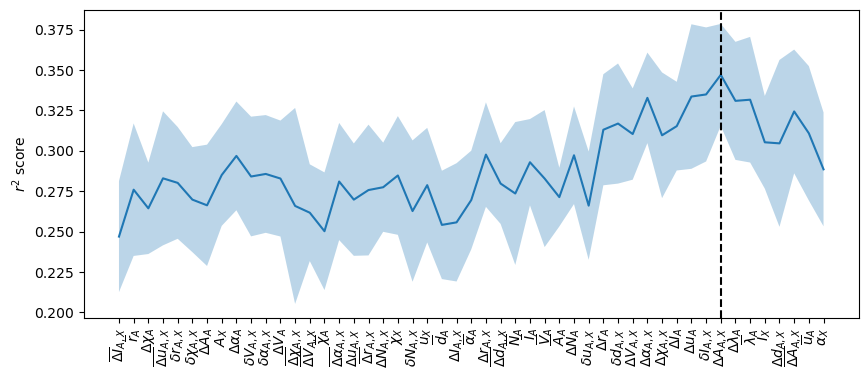

In [76]:
plt.figure(figsize=(10,4))

col_syms=[col_to_sym(p) for p in best_drop_logma]
print(col_syms)
plt.plot(col_syms,best_val_mean)
plt.fill_between(col_syms,np.array(best_val_mean)-np.array(best_val_std)/np.sqrt(10),np.array(best_val_mean)+np.array(best_val_std)/np.sqrt(10),alpha=0.3)

plt.axvline(x=np.argmax(best_val_mean),linestyle='--',color="black")
plt.ylabel("$r^2$ score")

plt.xticks(rotation=90);
plt.savefig("backwards-elim-logma-12-12.jpg")

In [77]:
import pickle
with open("axis_classifier-1201.pkl","rb") as f:
    best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std,\
best_param_list,grid_clf_list,grid_df_list,t_star=pickle.load(f)

In [78]:
col_star

['Abar_rad',
 'dA_volume',
 'dA_nup',
 'dA_electronegativity',
 'X_dipole',
 'Abar-X_electron_affinity',
 'Abar_electron_affinity',
 'Abar_nup',
 'Abar-X_nvalence']

['$\\overline{V}_{A}$', '$\\overline{\\lambda}_{A}$', '$\\Delta r_{A}$', '$\\Delta d_{A,X}$', '$\\chi_{X}$', '$\\Delta I_{A,X}$', '$A_{X}$', '$V_{X}$', '$u_{X}$', '$\\Delta \\alpha_{A,X}$', '$\\Delta I_{A}$', '$\\Delta d_{A}$', '$I_{X}$', '$\\Delta \\alpha_{A}$', '$\\overline{d}_{A}$', '$\\Delta V_{A,X}$', '$\\Delta r_{A,X}$', '$\\Delta u_{A,X}$', '$\\Delta \\lambda_{A}$', '$\\overline{\\alpha}_{A}$', '$\\overline{\\chi}_{A}$', '$\\Delta A_{A}$', '$\\overline{r}_{A}$', '$\\Delta V_{A}$', '$\\Delta u_{A}$', '$\\Delta \\chi_{A}$', '$\\alpha_{X}$', '$\\Delta A_{A,X}$', '$\\overline{A}_{A}$', '$\\overline{u}_{A}$', '$\\Delta N_{A,X}$']


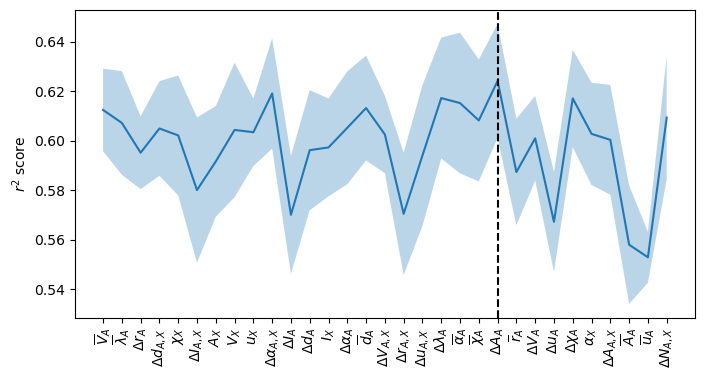

In [81]:
plt.figure(figsize=(8,4))

col_syms=[col_to_sym(p) for p in best_drop]
print(col_syms)

plt.plot(col_syms,best_val_mean)
plt.fill_between(col_syms,np.array(best_val_mean)-np.array(best_val_std)/np.sqrt(10),np.array(best_val_mean)+np.array(best_val_std)/np.sqrt(10),alpha=0.3)

plt.axvline(x=np.argmax(best_val_mean),linestyle='--',color="black")
plt.ylabel("$r^2$ score")

plt.xticks(rotation=90);
plt.savefig("backwards-elim-axis-12-12.jpg")

23

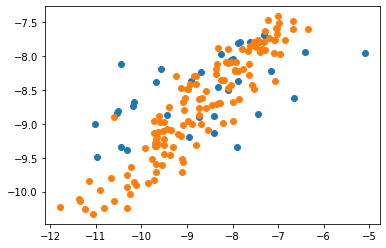

In [844]:
from numpy import e
y_predtrain=logma_clf.predict(logma_X_tr_star)
y_predt=logma_clf.predict(logma_X_val_star)
adjusted_ys=[e**a for a in [logma_y_val,y_predt,logma_y_train,y_predtrain]]

#regression_plot(*adjusted_ys,pred_value="$E_\mathrm{MA}$",xlimits=[e**(min(logma_y_train)*1.05),e**(max(logma_y_train)*0.95)],ylimits=[e**(min(logma_y_train)*1.05),e**(max(logma_y_train)*0.95)])
plt.scatter(logma_y_val,y_predt)
plt.scatter(logma_y_train,y_predtrain)


In [849]:
logma_clf

RandomForestRegressor(max_depth=12, max_features=1, min_samples_split=5,
                      n_estimators=47)

In [861]:
clf2=RandomForestRegressor(max_depth=12, max_features=1, min_samples_split=5,
                      n_estimators=47)
train_and_eval_regressor(RandomForestRegressor,logma_X_tr_star,logma_y_train,logma_X_val_star,logma_y_val,model_params=dict(max_depth=12, max_features=1, min_samples_split=5,
                      n_estimators=47));

R^2 Train: 0.7649524143473029
R^2 Test: 0.30139131206658476
7-fold cv: average R^2 = 0.2322800618883339, std = 0.15704897831400566


In [862]:
logma_X_tr_star.columns

Index(['Abar_nup', 'X_dipole', 'dAXbar_electron_affinity', 'X_ion_energy',
       'Abar-X_num_d', 'Abar_SOCC', 'dA_num_d', 'dA_SOCC', 'X_volume',
       'dAXbar_nvalence', 'ddAX_electron_affinity'],
      dtype='object')

In [870]:

X_try=X_comb[list(logma_X_tr_star.columns)+["dAXbar_electronegativity","AXsumbar_rad"]+list(X_comb.filter(like="coulomb").columns)]
y=data["log_MA"]

from sklearn.model_selection import train_test_split

X_org, X_test, y_org, y_test = train_test_split(X_try, y, test_size=0.1,random_state=70)
X_torg, X_val, y_torg, y_val = train_test_split(X_org,y_org, test_size=0.1,random_state=71)
X_train,y_train=X_torg,y_torg

In [874]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

model_type=RandomForestRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': [50,100,200],
                 'max_depth': [8,10,12,14,16],
                 'max_features':[6,8,10,1.0],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf2,grid_df2=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params2=grid_clf2.best_params_

Fitting 7 folds for each of 540 candidates, totalling 3780 fits


In [876]:
best_params2

{'max_depth': 12,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 65}

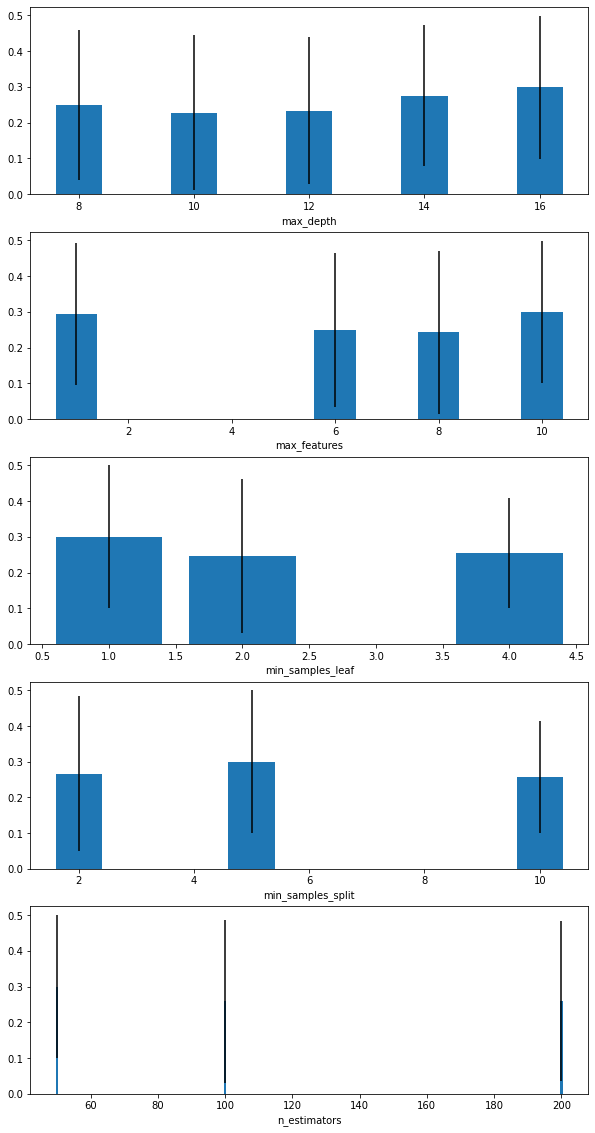

In [878]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df2.set_index(list(best_params2))
for i,p in enumerate(best_params2):
    ax=plt.subplot(len(best_params2),1,i+1)
    others=[x for x in best_params2 if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params2[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

R^2 Train: 0.9038808071838977
R^2 Test: 0.4994352592016428
7-fold cv: average R^2 = 0.2599719907074199, std = 0.22570796211732744


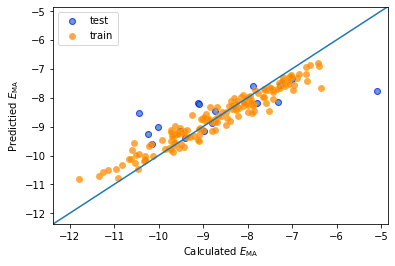

In [880]:
test_params=dict(best_params)
# test_params["oob_score"]=False
# test_params["max_samples"]

clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_val,y_val,model_params=test_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

In [882]:
best_clf=clf
best_y_predt=y_predt
best_y_predtrain=y_predtrain
best_test_params=test_params

R^2 Train: 0.8967720903046902
R^2 Test: 0.5340474567620925
7-fold cv: average R^2 = 0.24024955260371147, std = 0.21249050867210395


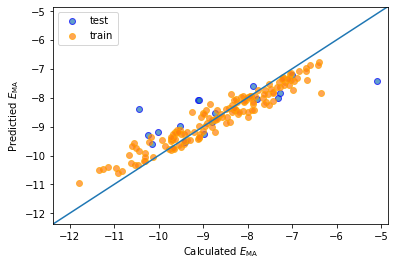

In [885]:
test_params=dict(best_params)
# test_params["oob_score"]=False
# test_params["max_samples"]

clf,y_predt,y_predtrain,_,_=train_and_eval_regressor(model_type,X_train,y_train,X_val,y_val,model_params=test_params)

regression_plot(y_val,y_predt,y_train,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])

In [987]:
#pickle.dump((clf,X_train,y_train,X_val,y_val,test_params,y_predt,y_predtrain,import_means,import_std,X_train_sets[0].columns),open("logma_model_323.pkl","wb"))

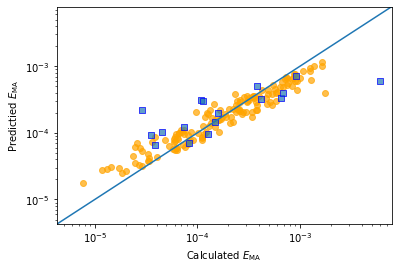

In [983]:
ey_val,ey_predt,ey_train,ey_predtrain=(e**a for a in [y_val,y_predt,y_train,y_predtrain])
plt.scatter(ey_train,ey_predtrain,alpha=0.7,color='orange',label="train")
plt.scatter(ey_val,ey_predt,alpha=0.7,edgecolor='blue',label="val",marker="s")

xlimits=[e**(min(y)*1.05),e**(max(y)*0.95)]
ylimits=[e**(min(y)*1.05),e**(max(y)*0.95)]
plt.plot(xlimits,ylimits)
plt.xlim(*xlimits)
plt.ylim(*ylimits)
plt.xlabel(r"Calculated $E_\mathrm{MA}$")
plt.ylabel(r"Predictied $E_\mathrm{MA}$")
#plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.savefig("figures/logma_pred-323.png")

In [978]:
print(f"val r2 = {metrics.r2_score(y_val,y_predt)}")
print(f"val mae = {metrics.mean_absolute_error(y_val,y_predt)}")
print(f"train r2 = {metrics.r2_score(y_train,y_predtrain)}")
print(f"train mae = {metrics.mean_absolute_error(y_train,y_predtrain)}")

val r2 = 0.5340474567620925
val mae = 0.7004002963352666
train r2 = 0.8967720903046902
train mae = 0.3031513978710493


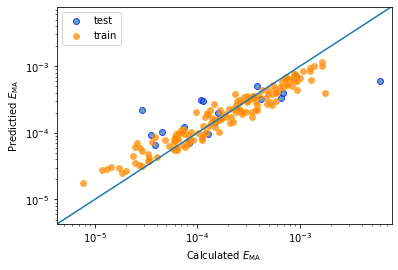

In [957]:
adjusted_ys=[e**a for a in [y_val,y_predt,y_train,y_predtrain]]

regression_plot(*adjusted_ys,pred_value="$E_\mathrm{MA}$",xlimits=[e**(min(y)*1.05),e**(max(y)*0.95)],ylimits=[e**(min(y)*1.05),e**(max(y)*0.95)])
plt.xscale("log")
plt.yscale("log")
savefig()

In [945]:
N_sets=20

X_val_sets=[]
y_val_sets=[]
X_train_sets=[]
y_train_sets=[]

for i in range(N_sets):
    X_torg_n, X_val_n, y_torg_n, y_val_n = train_test_split(X_org,y_org, test_size=0.1)
    X_train_n,y_train_n=X_torg_n,y_torg_n
    X_train_sets.append(X_train_n)
    y_train_sets.append(y_train_n)
    X_val_sets.append(X_val_n)
    y_val_sets.append(y_val_n)

0


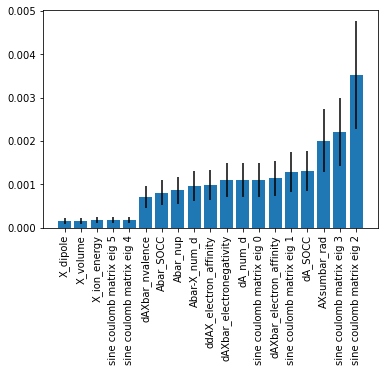

In [950]:
#plt.figure(figsize=(10,10));
importances,import_means,import_std=calc_importances(model_type,X_train_sets,y_train_sets,model_params=test_params);

plt.xticks(rotation=90);


In [48]:
import pickle
clf,X_train,y_train,X_val,y_val,test_params,y_predt,y_predtrain,import_means,import_std,cols=pickle.load(open("logma_model_323.pkl","rb"))

In [49]:
cols

Index(['Abar_nup', 'X_dipole', 'dAXbar_electron_affinity', 'X_ion_energy',
       'Abar-X_num_d', 'Abar_SOCC', 'dA_num_d', 'dA_SOCC', 'X_volume',
       'dAXbar_nvalence', 'ddAX_electron_affinity', 'dAXbar_electronegativity',
       'AXsumbar_rad', 'sine coulomb matrix eig 0',
       'sine coulomb matrix eig 1', 'sine coulomb matrix eig 2',
       'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4',
       'sine coulomb matrix eig 5'],
      dtype='object')

In [9]:
for i,j in zip(y_val,y_predt):
    print(i,j)

-10.15105187838296 -9.618034568919581
-9.121551409156632 -8.07135136628364
-7.7847892406547565 -8.04867075812928
-7.871425919901791 -7.593118037231704
-7.328488859221895 -8.004461795589211
-9.4027122646292 -9.54550366045331
-9.087238174842199 -8.096156675854228
-5.106156046069459 -7.430692375701875
-10.246823289171429 -9.299696686052082
-9.512053757823482 -8.992991995965316
-8.975742670611321 -9.259489742828016
-6.998260023407539 -7.231399027659772
-10.002203525474714 -9.189109766659087
-7.284683951949887 -7.837809307296993
-8.804442024399124 -8.832813540989875
-10.44821472805241 -8.40289852288498
-8.742839872949192 -8.51880502590981


In [10]:
np.e**-7.430692375701875

0.0005927769454370126

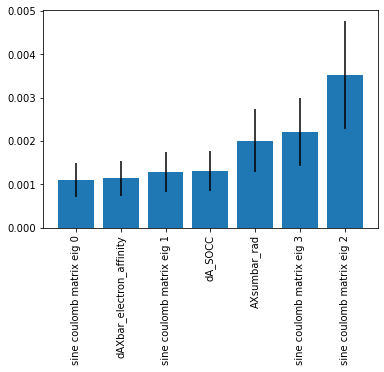

In [23]:
sorted_idx=import_means.argsort()[-7:]
plt.bar(cols[sorted_idx],import_means[sorted_idx],yerr=import_std[sorted_idx]/20)
plt.xticks(rotation=90);

In [994]:
def training_curve(model_type,X_train_set,y_train_set,X_test_set,y_test_set,model_params={},scoring='r2',save_file=None):

    ts=np.arange(0.1,1,0.1)
    scores=np.zeros((len(ts),len(X_train_set)))
    for i in range(len(ts)):
        t=ts[i]
        print(t)
        for j in range(len(X_train_set)):
            X_t, _, y_t, _ = train_test_split(X_train_set[j], y_train_set[j], test_size=1-t)
            model=model_type(**model_params)
            model.fit(X_t,y_t)
            y_predt=model.predict(X_test_set[j])
            if scoring=='r2':
                scores[i][j]=metrics.r2_score(y_test_set[j],y_predt)
            elif scoring=='f1-macro':
                scores[i][j]=metrics.f1_score(y_test_set[j],y_predt,average='macro')
                
    avg_score=np.mean(scores,axis=1)
    std_score=np.std(scores,axis=1)
    
    plt.plot(ts,avg_score)
    plt.fill_between(ts,avg_score-std_score,avg_score+std_score,alpha=0.3)
    plt.xlabel("Fraction of training set used")
    if scoring=='r2':
        plt.ylabel("$r^2$ score")
    elif scoring=='f1-macro':
        plt.ylabel("$F_1$ macro score")
    if save_file is not None:
        savefig(save_file)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


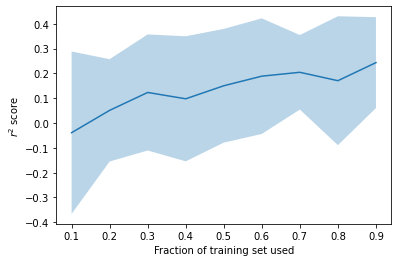

In [995]:
training_curve(model_type,X_train_sets,y_train_sets,X_val_sets,y_val_sets,model_params=test_params)

In [986]:
import_means,import_std,X_train_sets[0].columns

(array([0.00086171, 0.0001583 , 0.00114616, 0.00017355, 0.00096695,
        0.00081262, 0.00110173, 0.00130414, 0.00016401, 0.00070927,
        0.00098683, 0.00109735, 0.00201218, 0.00110685, 0.00129406,
        0.00353149, 0.00220828, 0.00018749, 0.00017705]),
 array([0.00612176, 0.00126702, 0.00808919, 0.00144718, 0.00683519,
        0.00578693, 0.00783087, 0.00917127, 0.00139545, 0.00499796,
        0.00696638, 0.00780846, 0.01441753, 0.00782998, 0.00914525,
        0.02485806, 0.0156457 , 0.00140406, 0.00139632]),
 Index(['Abar_nup', 'X_dipole', 'dAXbar_electron_affinity', 'X_ion_energy',
        'Abar-X_num_d', 'Abar_SOCC', 'dA_num_d', 'dA_SOCC', 'X_volume',
        'dAXbar_nvalence', 'ddAX_electron_affinity', 'dAXbar_electronegativity',
        'AXsumbar_rad', 'sine coulomb matrix eig 0',
        'sine coulomb matrix eig 1', 'sine coulomb matrix eig 2',
        'sine coulomb matrix eig 3', 'sine coulomb matrix eig 4',
        'sine coulomb matrix eig 5'],
       dtype='object'))

In [949]:
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
df_val = data.loc[y_val.index]
df_val["y_pred"]=y_predt
df_val["y_true"]=y_val
df_val["set"]="val"
df_train = data.loc[y_train.index]
df_train["y_pred"]=y_predtrain
df_train["y_true"]=y_train
df_train["set"]="train"
df_all=pd.concat([df_val,df_train])
px.scatter(df_all, x="y_true", y="y_pred", color="set",hover_data=['Material'])


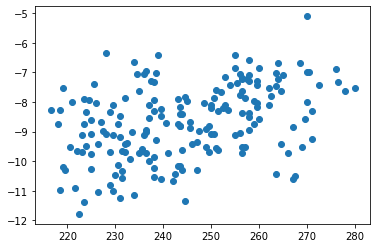

In [1014]:
plt.scatter(X_comb["AXsumbar_rad"],y)

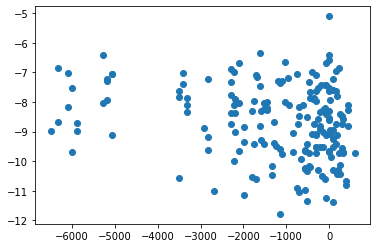

In [1005]:
plt.scatter(X_comb["dA_SOCC"],y)

In [1001]:
X_comb.filter(like="sumbar")

AXsumbar_rad
0           218.5
1           228.0
2           226.0
3           239.0
4           265.0
..            ...
180         260.0
181         280.0
182         237.0
183         250.0
184         270.0

[185 rows x 1 columns]

In [953]:
df_val["err"]=abs(df_val["y_true"]-df_val["y_pred"])
df_val[["Material","err"]]

Material       err
313    1T-V1Nb1S4  0.533017
87    1T-Fe1Au1S4  1.050200
222   1T-Mn1V1Te4  0.263882
198  1T-Mn1Pt1Te4  0.278308
44   1T-Cr1Ir1Se4  0.675973
148   1T-Mn1Ag1S4  0.142791
362      1T-V2Se4  0.991081
363      1T-V2Te4  2.324536
128   1T-Fe1Tc1S4  0.947127
185  1T-Mn1Nb1Se4  0.519062
98    1T-Fe1Hg1S4  0.283747
70   1T-Cr1Ta1Te4  0.233139
68    1T-Cr1Ta1S4  0.813094
66   1T-Cr1Ru1Te4  0.553125
93   1T-Fe1Co1Te4  0.028372
219  1T-Mn1Ti1Te4  2.045316
294   1T-V1Cu1Te4  0.224035

In [1016]:
test_params

{'max_depth': 12,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 65}

# axis ML

In [19]:
old_dt=pd.read_csv("MA_data.csv")
X_old=old_dt[['A1_rad', 'A2_rad',
       'X_rad', 'Abar_rad', 'dA_rad', 'Abar-X_rad', 'dAXbar_rad', 'ddAX_rad',
       'A1_dipole', 'A2_dipole', 'X_dipole', 'Abar_dipole', 'dA_dipole',
       'Abar-X_dipole', 'dAXbar_dipole', 'ddAX_dipole', 'A1_nvalence',
       'A2_nvalence', 'X_nvalence', 'Abar_nvalence', 'dA_nvalence',
       'Abar-X_nvalence', 'dAXbar_nvalence', 'ddAX_nvalence', 'A1_nup',
       'A2_nup', 'X_nup', 'Abar_nup', 'dA_nup', 'Abar-X_nup', 'dAXbar_nup',
       'ddAX_nup', 'A1_num_d', 'A2_num_d', 'X_num_d', 'Abar_num_d', 'dA_num_d',
       'Abar-X_num_d', 'dAXbar_num_d', 'ddAX_num_d', 'A1_volume', 'A2_volume',
       'X_volume', 'Abar_volume', 'dA_volume', 'Abar-X_volume',
       'dAXbar_volume', 'ddAX_volume', 'A1_ion_energy', 'A2_ion_energy',
       'X_ion_energy', 'Abar_ion_energy', 'dA_ion_energy', 'Abar-X_ion_energy',
       'dAXbar_ion_energy', 'ddAX_ion_energy', 'A1_electron_affinity',
       'A2_electron_affinity', 'X_electron_affinity', 'Abar_electron_affinity',
       'dA_electron_affinity', 'Abar-X_electron_affinity',
       'dAXbar_electron_affinity', 'ddAX_electron_affinity',
       'A1_electronegativity', 'A2_electronegativity', 'X_electronegativity',
       'Abar_electronegativity', 'dA_electronegativity',
       'Abar-X_electronegativity', 'dAXbar_electronegativity',
       'ddAX_electronegativity', 'A1_SOCC', 'A2_SOCC', 'Abar_SOCC', 'dA_SOCC']]

In [20]:
X_comb=pd.concat([X.reset_index()[['sine coulomb matrix eig 0', 'sine coulomb matrix eig 1',
       'sine coulomb matrix eig 2', 'sine coulomb matrix eig 3',
       'sine coulomb matrix eig 4', 'sine coulomb matrix eig 5']], X_old], axis = 1)
X_comb["AXsumbar_rad"]=(X_comb["A1_rad"]+X_comb["A2_rad"])/2+X_comb["X_rad"]
X_comb=X_comb.drop(list(X_comb.filter(like="A1").columns)+list(X_comb.filter(like="A2").columns),axis=1)

In [21]:
corr_tab=X_comb.corr()

for feature in corr_tab:
    if all(np.isnan(corr_tab[feature])):
        print(feature)
        X_comb.drop(feature,axis=1)

X_nvalence
X_nup


In [35]:
comb_dt=pd.concat([old_dt[["Material","sign_MA","log_MA"]],X_comb],axis=1)
comb_dt.to_csv("log_MA_dat_ext.csv")

In [22]:
def confusion_mat(mat,**kwargs):
    group_counts = ["{0:0.0f}".format(value) for value in
                mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(mat, annot=labels, fmt='', **kwargs)

#confusion_mat(train_mat)
from sklearn.ensemble import RandomForestClassifier

def train_and_eval_classifier(model_type,X_train,y_train,X_test,y_test,model_params={},do_print=True):
    print("test")
    clf=model_type(**model_params)
    clf.fit(X_train,y_train)

    y_predt=clf.predict(X_test)
    y_pred_train=clf.predict(X_train)
    
    train_mat=metrics.confusion_matrix(y_train,y_pred_train)
    train_f1_score=metrics.f1_score(y_train,y_pred_train,average='macro')
    test_mat=metrics.confusion_matrix(y_test,y_predt)
    test_f1_score=metrics.f1_score(y_test,y_predt,average='macro')
    
    if do_print:
        print(f"train confusion matrix: {train_mat}")
        print(f"train f1-score: {train_f1_score}")

        print(f"test confusion matrix: {test_mat}")

        print(f"test f1-score: {test_f1_score}")
    return clf,test_mat,train_mat,test_f1_score,train_f1_score
    

In [23]:
from sklearn.model_selection import train_test_split

X=X_comb
y=old_dt["sign_MA"]

X_org, X_test, y_org, y_test = train_test_split(X, y, test_size=0.1,random_state=45)
X_torg, X_val, y_torg, y_val = train_test_split(X_org,y_org, test_size=0.1,random_state=46)

X_train,y_train=X_torg,y_torg

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

param_grid = {
                 'n_estimators': range(2,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,4,6,8,10],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }


from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier()
grid_clf,grid_df=hyper_param_search(clf,param_grid,X_train,y_train,cv=7,verbose=10,n_jobs=6)
best_params=grid_clf.best_params_

Fitting 7 folds for each of 6048 candidates, totalling 42336 fits


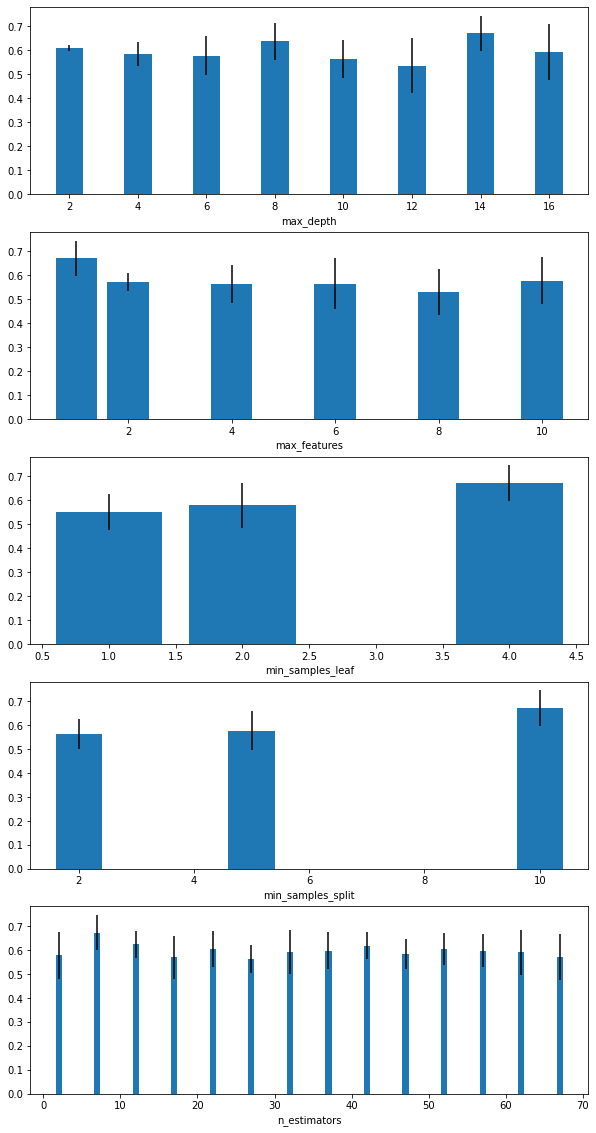

In [50]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df.set_index(list(best_params))
for i,p in enumerate(best_params):
    ax=plt.subplot(len(best_params),1,i+1)
    others=[x for x in best_params if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

In [51]:
model_type=RandomForestClassifier

In [52]:
N_sets=7

X_val_sets=[]
y_val_sets=[]
X_train_sets=[]
y_train_sets=[]

for i in range(N_sets):
    X_torg_n, X_val_n, y_torg_n, y_val_n = train_test_split(X_org,y_org, test_size=0.1)
    X_train_n,y_train_n=X_torg_n,y_torg_n
    X_train_sets.append(X_train_n)
    y_train_sets.append(y_train_n)
    X_val_sets.append(X_val_n)
    y_val_sets.append(y_val_n)

0


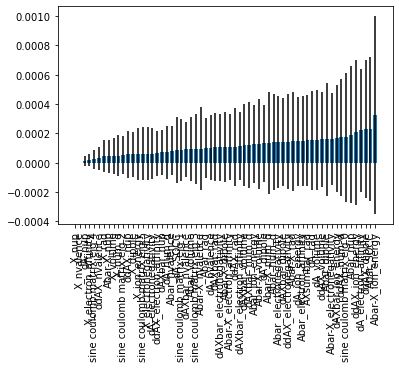

In [57]:
calc_importances(model_type,X_train_sets,y_train_sets,model_params=best_params);
plt.xticks(rotation=90);

In [59]:
best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std=backwards_elim(model_type,
                                                          X_train_sets,
                                                          y_train_sets,
                                                          X_val_sets,
                                                          y_val_sets,
                                                          param_grid,
                                                          scoring='f1_macro',
                                                          model_params=best_params,
                                                          all_drops=[],is_classifier=True)

Index(['sine coulomb matrix eig 0', 'sine coulomb matrix eig 1',
       'sine coulomb matrix eig 2', 'sine coulomb matrix eig 3',
       'sine coulomb matrix eig 4', 'sine coulomb matrix eig 5', 'X_rad',
       'Abar_rad', 'dA_rad', 'Abar-X_rad', 'dAXbar_rad', 'ddAX_rad',
       'X_dipole', 'Abar_dipole', 'dA_dipole', 'Abar-X_dipole',
       'dAXbar_dipole', 'ddAX_dipole', 'X_nvalence', 'Abar_nvalence',
       'dA_nvalence', 'Abar-X_nvalence', 'dAXbar_nvalence', 'ddAX_nvalence',
       'X_nup', 'Abar_nup', 'dA_nup', 'Abar-X_nup', 'dAXbar_nup', 'ddAX_nup',
       'X_num_d', 'Abar_num_d', 'dA_num_d', 'Abar-X_num_d', 'dAXbar_num_d',
       'ddAX_num_d', 'X_volume', 'Abar_volume', 'dA_volume', 'Abar-X_volume',
       'dAXbar_volume', 'ddAX_volume', 'X_ion_energy', 'Abar_ion_energy',
       'dA_ion_energy', 'Abar-X_ion_energy', 'dAXbar_ion_energy',
       'ddAX_ion_energy', 'X_electron_affinity', 'Abar_electron_affinity',
       'dA_electron_affinity', 'Abar-X_electron_affinity',
       'dA

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Aba

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'ddAX_nvalence', 'Abar_num_

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', '

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'si

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 's

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb ma

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'ddAX_dipole', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nva

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_n

+test
+test
+test
+test
+test

testing ('Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'si

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb 

+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix ei

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d',

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matri

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_electronegativity', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matr

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix ei

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine c

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d'

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAX

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'X_volume', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_d

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_d

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', '

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipo


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_rad', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'd


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_en

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXb

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_ener

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'd

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'dAXbar_electronegativity', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_ra


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'dA_SOCC', 'Abar-X_dipol

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Ab

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', '


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'dA_SOCC', '

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'dA_SOCC

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'dA_SOCC', 'A

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', '

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SO

+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC'


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_d

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy',


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'dA_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddA

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'd

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Aba

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', '

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy',

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'sine coulomb matrix eig 4', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC'

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegati

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole',


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (20/55):+test


testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (28/5

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole',

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (4

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'ddAX_volume', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole') (53/55):+test


+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_elect

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electroneg

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_elect

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electrone

+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (40/54):+test
+test
+tes

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_volume', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (49/5

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (3/53):+test
+tes

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (12/53):+test
+test
+

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (21/53):+test
+te

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (31/53):+test
+test
+t

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (40/53):+

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_ion_energy', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (49/53):+test
+test
+test
+tes

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (6/52):+test
+test
+te

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (15/52):+test
+test
+test
+tes

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (25/52):+test
+test
+test
+test
+


testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (34/52):+test
+test
+test
+test
+test
+test
+test

testing (

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_rad', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (44/52):+test
+test
+test
+test
+test
+test
+test

te

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (2/51):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_n

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (12/51):+test
+test
+test
+test
+test
+test
+test

t

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (21/51):+test
+test
+test
+test
+test
+test
+tes


testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (30/51):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvale

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (39/51):+test
+test
+test
+test
+test
+tes

+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'sine coulomb matrix eig 5', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (48/51):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (7/50):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X

+test
+test
+test
+test
+test

testing ('sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (17/50):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalenc

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (27/50):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nv

+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (36/50):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matr

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'sine coulomb matrix eig 2', 'Abar_electron_affinity', 'Abar_rad', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'Abar-X_dipole', 'ddAX_electronegativity') (45/50):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence

+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (4/49):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegati

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (13/49):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affini

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (22/49):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affini

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (32/49):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'X_rad', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (41/49):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA

+test
+test
+test
+test

best result was dropping: X_rad with val score 0.5790695240613515+-0.05446618032413101 and training score 0.7855387120432482+-0.014782530364646766
testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (10/48):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (19/48):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electroneg

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_electron_affinity', 'dAXbar_nvalence', 'dA_nup', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (29/48):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (38/48):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_aff


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'AXsumbar_rad', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (47/48):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronega

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (8/47):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (18/47):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (28/47):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity'

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'sine coulomb matrix eig 3', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (38/47):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_elec

+test
+test
+test
+test
+test
+test

best result was dropping: sine coulomb matrix eig 3 with val score 0.524827081131429+-0.07470658378288832 and training score 0.7787613538031818+-0.01446104803690579
testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (11/46):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', '

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (22/46):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (33/46):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'dA_rad', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (43/46):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', '

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (8/45):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (18/45):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_af

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (29/45):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity'

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'dA_nup', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (40/45):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', '

+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (5/44):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalenc


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (24/44):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (34/44):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole',

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_nup', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (44/44):+test
+test
+test
+test
+test
+test
+test

best result was dropping: dAXbar_nup with val score 0.5534629793946564+-0.040559766630371294 and t

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (10/43):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_r

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (20/43):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'A

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (30/43):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_el

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'dA_electron_affinity', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (41/43):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', '

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (8/42):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dip

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (19/42):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', '

+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (29/42):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', '

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'ddAX_nup', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'sine coulomb matrix eig 2', 'ddAX_electronegativity') (40/42):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity',

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (10/41):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole'

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (21/41):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_io

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'dA_ion_energy', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (32/41):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence',

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (2/40):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nv

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (14/40):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (25/40):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_num_d', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (36/40):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_elect


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (7/39):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affi

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (19/39):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'dAXbar_dipole', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (30/39):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (3/38):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalen


testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (14/38):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', '

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (26/38):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity',

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'dA_dipole', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup', 'ddAX_electronegativity') (38/38):+test
+test
+test
+test
+test
+test
+test

best result was dropping: dA_dipole with val score 0.530764163372859+-0.03351369526380607 and training score 0.7810628475291654+-0.012438456065968955
testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electro

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (12/37):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulo

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup', 'ddAX_electronegativity') (24/37):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity'

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (36/37):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1

+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (11/36):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1'

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (24/36):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAX

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_electronegativity', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup') (36/36):+test
+test
+test
+test
+test
+test
+test

best result was dropping: Abar-X_electronegativity with val score 0.5305963842920365+-0.028646198751664784 and training score 0.7611137996167961+-0.023772309777727048
testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electro

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (13/35):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_io

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (26/35):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'X_nup', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X

+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (4/34):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (18/34):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy'

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'Abar_SOCC', 'ddAX_nup') (31/34):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_ener

+test
+test
+test
+test
+test

testing ('Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup') (10/33):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dA

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup') (23/33):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar_electron_affinity', 'dA_electronegativity', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup') (3/32):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_i

+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (16/32):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_e

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'X_num_d', 'ddAX_nup') (31/32):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity

+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (13/31):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affin

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (27/31):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_ion_energy', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_af

+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (11/30):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Aba

+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (26/30):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar-X_dipole', 'Abar_nup', 'Abar-X_nup'

+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'ddAX_nup') (11/29):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar-X_nup', 'Abar_dipol

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (27/29):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'dA_electronegativity', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', '

+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (13/28):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipo


testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'dAXbar_electron_affinity', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (28/28):+test
+test
+test
+test
+test
+test
+test

best result was dropping: dAXbar_electron_affinity with val score 0.5238734357792874+-0.046834391502621094 and training score 0.7649487455783348+-0.013168574373154761
testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy',

+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (16/27):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'ddAX_electron_affinity', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nva


testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (5/26):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (6/26):+test
+test
+test
+test
+test
+

+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (22/26):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar-X_volume', 'Abar_nvalence', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (23/26):+test
+test


+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (13/25):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'X_nvalence', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d') (14/25):+test
+test
+test
+test
+test


+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (6/24):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (7/24):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_

+test
+test

testing ('Abar-X_nvalence', 'Abar-X_electron_affinity', 'ddAX_rad', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (24/24):+test
+test
+test
+test
+test
+test
+test

best result was dropping: Abar-X_nvalence with val score 0.5637606120950351+-0.030510582896487528 and training score 0.7705211611061252+-0.012198761117640271
testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'dA_nvalence', 'ddAX_nvalence', 

+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (18/23):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'X_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (19/23):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_ele

+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (15/22):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar-X_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (16/22):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence',

+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'ddAX_nup') (12/21):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d', 'ddAX_nup') (13/21):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'Abar_electronegativity', 'ddAX_num_d', 'dAXbar_nvalence', 'sine

+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'Abar_num_d') (11/20):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion_energy', 'X_electron_affinity', 'Abar_nup', 'Abar_dipole', 'dA_num_d', 'dAXbar_num_d', 'X_dipole', 'sine coulomb matrix eig 0', 'dA_nvalence', 'ddAX_nvalence', 'ddAX_nup') (12/20):+test
+test
+test
+test
+test
+test
+test

testing ('Abar-X_electron_affinity', 'ddAX_rad', 'ddAX_num_d', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'dAXbar_volume', 'Abar_nvalence', 'dAXbar_ion_energy', 'Abar-X_ion

+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'X_electron_affinity', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup') (13/19):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'X_dipole', 'dAXbar_nvalence', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'X_electron_affinity', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (14/19):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'dAXbar_nvalence', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'X_electron_affinity', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar

+test
+test

testing ('ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'X_electron_affinity', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (16/18):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'ddAX_rad', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (17/18):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'X_electron_affinity', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'ddAX_rad', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', '

+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (5/16):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (6/16):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'ddAX_num_d', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (7/16):+test
+test
+test
+test
+te


testing ('dAXbar_ion_energy', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'dA_nvalence', 'Abar_num_d', 'dAXbar_volume', 'Abar_nup', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (15/15):+test
+test
+test
+test
+test
+test
+test

best result was dropping: Abar_num_d with val score 0.5444105983007584+-0.03125337364451373 and training score 0.7948366737778251+-0.005817253857233563
testing ('dAXbar_ion_energy', 'X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (1/14):+test
+test
+test
+test
+test
+test
+test

testing ('dAXbar_ion_energy', 'X_dipole', 'Abar-X_ion_energy', 'sine coulomb matrix eig 0', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (2/14):+test
+test
+tes

+test
+test
+test
+test
+test
+test

best result was dropping: sine coulomb matrix eig 0 with val score 0.5591037671783013+-0.03295369463701749 and training score 0.7693162667117283+-0.007675649050541527
testing ('X_dipole', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (1/12):+test
+test
+test
+test
+test
+test
+test

testing ('sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (2/12):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar-X_electron_affinity', 'Abar_nvalence', 'dA_num_d', 'ddAX_nup', 'dAXbar_num_d') (3/12):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X

+test

testing ('sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d') (2/9):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar_nvalence', 'dA_num_d') (3/9):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_nup', 'Abar_dipole', 'dA_num_d') (4/9):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dAXbar_volume', 'Abar_nup', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d') (5/9):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'sine coulomb matrix eig 1', 'Abar-X_ion_energy', 'dA_nvalence', 'dAXbar_volume', 'Abar_dipole', 'Abar_nvalence', 'dA_num_d') (6/9):+test
+test
+test
+test
+test
+test
+test

testing ('X_dipole', 'si

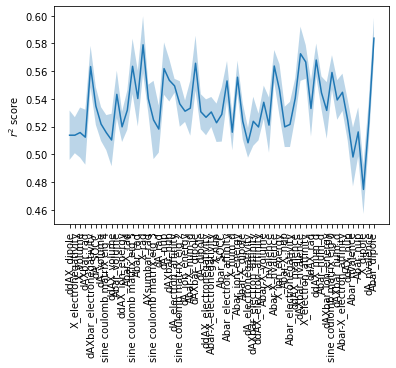

In [63]:
# plt.plot(best_drop,best_tr_mean)
# fill_between(best_drop,array(best_tr_mean)-array(best_tr_std)/N_sets,array(best_tr_mean)+array(best_tr_std)/N_sets,alpha=0.3)


plt.plot(best_drop,best_val_mean)
plt.fill_between(best_drop,np.array(best_val_mean)-np.array(best_val_std)/N_sets,np.array(best_val_mean)+np.array(best_val_std)/N_sets,alpha=0.3)

plt.ylabel("$r^2$ score")

plt.xticks(rotation=90)

plt.savefig("axis_class_backelim-328.pdf")

In [64]:
best_cols=max(all_val_mean,key=all_val_mean.get)
X_tr_star=X_train[list(best_cols)]
X_val_star=X_val[list(best_cols)]

In [122]:
best_cols2=list(set(list(best_cols)+["dAXbar_electronegativity","AXsumbar_rad"]+list(X_comb.filter(like="coulomb").columns)))
X_tr_star2=X_train[list(best_cols)]
X_val_star2=X_val[list(best_cols)]

In [123]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': range(30,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,4,6,8,10],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf3,grid_df3=hyper_param_search(clf,param_grid,X_tr_star2,y_train,cv=7,verbose=10,n_jobs=6)
best_params3=grid_clf3.best_params_

Fitting 7 folds for each of 3456 candidates, totalling 24192 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12096 fits failed out of a total of 24192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12096 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\ProgramData\Anaconda3\lib\site-pa

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


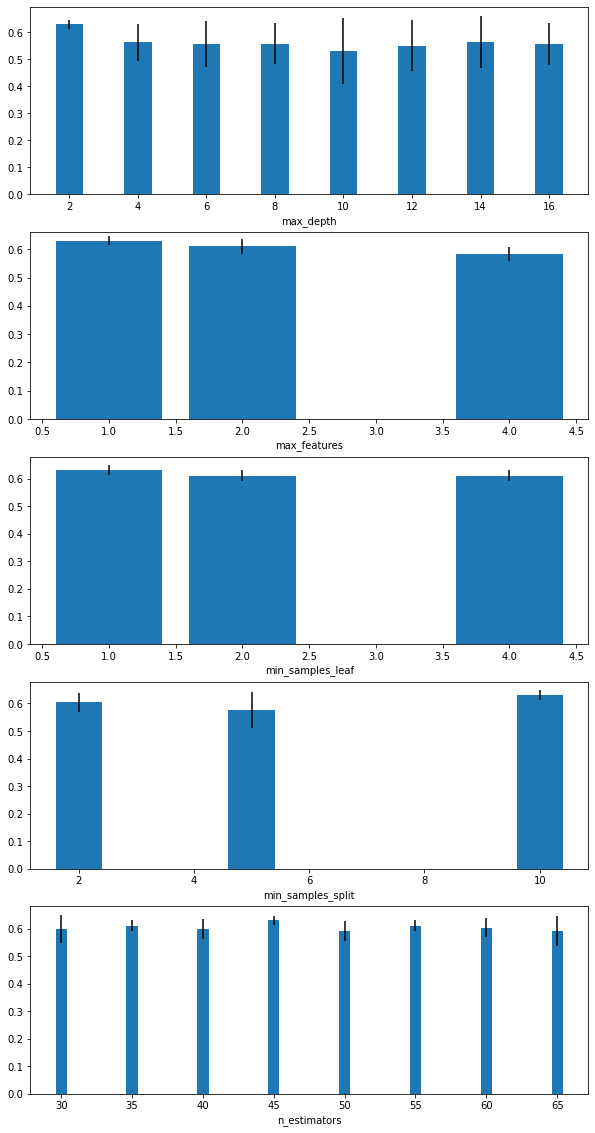

In [124]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df3.set_index(list(best_params3))
for i,p in enumerate(best_params3):
    ax=plt.subplot(len(best_params3),1,i+1)
    others=[x for x in best_params3 if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params3[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

In [134]:
clf_star,test_mat,train_mat,test_f1,train_f1=train_and_eval_classifier(RandomForestClassifier,X_train,y_train,X_val,y_val,model_params=best_params)

test
train confusion matrix: [[43 14]
 [ 8 84]]
train f1-score: 0.8402534113060429
test confusion matrix: [[2 5]
 [4 6]]
test f1-score: 0.43956043956043944


In [133]:
X_val_star_sets=[]
X_train_star_sets=[]

for xt,xv in zip(X_train_sets,X_val_sets):
#     X_val_star_sets.append(xv[list(best_cols2)])
#     X_train_star_sets.append(xt[list(best_cols2)])
    X_val_star_sets.append(xv)
    X_train_star_sets.append(xt)
    
scores=[]
i=0

plt.figure(figsize=(8, 30), dpi=80)

for xt,yt,xv,yv in zip(X_train_star_sets,y_train_sets,X_val_star_sets,y_val_sets):
    print("test")
    i+=1
    clf_i,_,_,_,_=train_and_eval_classifier(RandomForestClassifier,xt,yt,xv,yv,model_params=best_params)
    y_vpred_proba=clf_i.predict_proba(xv)[:,1]
    y_tpred_proba=clf_i.predict_proba(xt)[:,1]
    threshs=np.linspace(0,1,100)
    s_i=np.zeros_like(threshs)
    for j,t in enumerate(threshs):
        y_predthresh=(y_vpred_proba >= t).astype('int')*2-1
    
        s_i[j]=metrics.f1_score(yv,y_predthresh,average='macro')
    
    t_i=threshs[s_i.argmax()]
    print(max(s_i))
    y_vpred=(y_vpred_proba >= t_i).astype('int')*2-1
    
    s=metrics.f1_score(yv,y_vpred,average='macro')
    print(s)
    scores.append(s)
#    subplot(len(X_train_star_sets),1,i)
#    regression_plot(yv,y_predt,yt,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])
print(f"from {N_sets}-fold, average validation score of {np.mean(scores)}+-{np.std(scores)/np.sqrt(N_sets)}")

test
test
train confusion matrix: [[26 29]
 [ 3 91]]
train f1-score: 0.7347574543836226
test confusion matrix: [[0 9]
 [0 8]]
test f1-score: 0.31999999999999995
0.48484848484848486
0.48484848484848486
test
test
train confusion matrix: [[36 21]
 [ 8 84]]
train f1-score: 0.7828315826506509
test confusion matrix: [[1 6]
 [1 9]]
test f1-score: 0.47111111111111115
0.7017543859649122
0.7017543859649122
test
test
train confusion matrix: [[25 32]
 [ 4 88]]
train f1-score: 0.7057920140412461
test confusion matrix: [[3 4]
 [1 9]]
test f1-score: 0.6640316205533596
0.7424242424242424
0.7424242424242424
test
test
train confusion matrix: [[33 23]
 [ 8 85]]
train f1-score: 0.7630917577063138
test confusion matrix: [[2 6]
 [1 8]]
test f1-score: 0.5296442687747036
0.5296442687747036
0.5296442687747036
test
test
train confusion matrix: [[32 25]
 [ 3 89]]
train f1-score: 0.7798649219079781
test confusion matrix: [[1 6]
 [1 9]]
test f1-score: 0.47111111111111115
0.6640316205533596
0.6640316205533596
test


<Figure size 640x2400 with 0 Axes>

In [26]:
import pickle
with open("axis_classifier-1201.pkl","rb") as f:
    best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std,\
best_param_list,grid_clf_list,grid_df_list,t_star=pickle.load(f)

In [26]:
X_tr_star=X_train[col_star]
X_val_star=X_val[col_star]

In [29]:
best_params=best_param_list[np.array(best_val_mean).argmax()]

In [137]:
try_cols=list(set(list(col_star)+["dAXbar_electronegativity","AXsumbar_rad"]+list(X_comb.filter(like="coulomb").columns)))
X_tr_try=X_train[list(try_cols)]
X_val_try=X_val[list(try_cols)]

In [139]:
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor

# param_grid = {
#     'n_estimators': [10, 50, 100, 500],
#     'learning_rate': [0.0001, 0.001, 0.003,0.005,0.007,0.01, 0.1, 1.0],
# }

param_grid = {
                 'n_estimators': range(30,70,5),
                 'max_depth': [2,4,6,8,10,12,14,16],
                 'max_features':[1,2,4,6,8,10],
                 'min_samples_split':[2, 5, 10],
                'min_samples_leaf':[1, 2, 4]
             }

clf=model_type()

#clf=RandomForestRegressor() 
#grid_clf = GridSearchCV(clf, param_grid, X_train,y_train,cv=7)
# grid_clf.fit(X_train, y_train)


#cv_split=aug_kfold(X_torg,aug_index,n_splits=7,shuffle=True)

grid_clf4,grid_df4=hyper_param_search(clf,param_grid,X_tr_try,y_train,cv=7,verbose=10,n_jobs=6)
best_params4=grid_clf4.best_params_

Fitting 7 folds for each of 3456 candidates, totalling 24192 fits


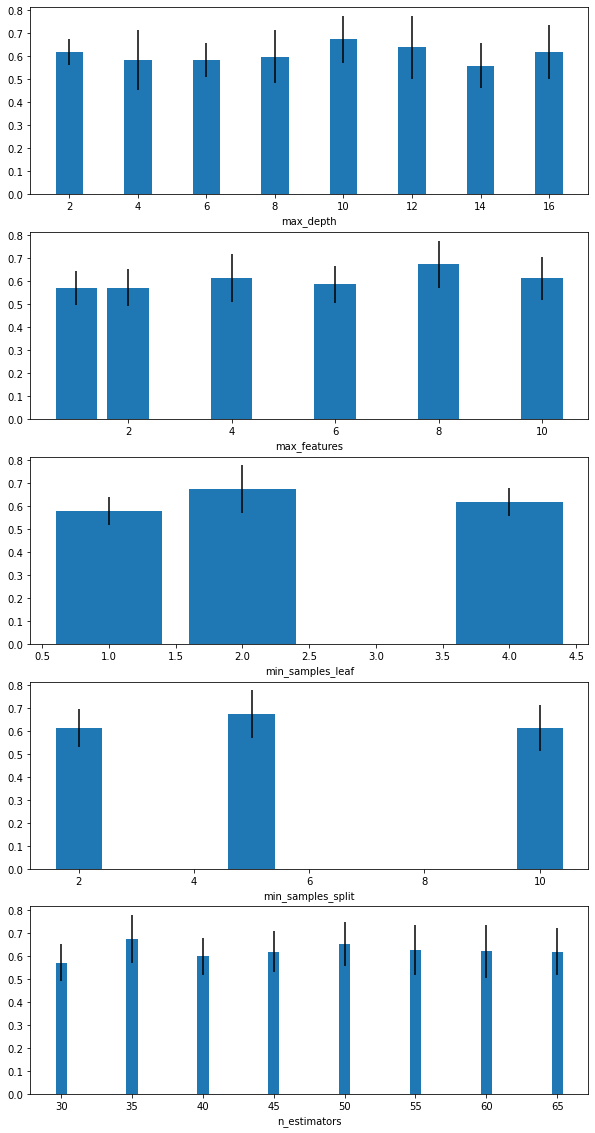

In [140]:
plt.figure(figsize=(10,20))
grid_ho_scores=grid_df4.set_index(list(best_params4))
for i,p in enumerate(best_params4):
    ax=plt.subplot(len(best_params4),1,i+1)
    others=[x for x in best_params4 if x!=p]
    ss=grid_ho_scores.xs(tuple(best_params4[x] for x in others),level=others)
    plt.bar(ss.index,ss["mean_test_score"],yerr=ss["std_test_score"])
    plt.xlabel(p)

In [141]:
clf_star,test_mat,train_mat,test_f1,train_f1=train_and_eval_classifier(RandomForestClassifier,X_tr_try,y_train,X_val_try,y_val,model_params=best_params4)

test
train confusion matrix: [[56  1]
 [ 0 92]]
train f1-score: 0.9928725185362354
test confusion matrix: [[2 5]
 [3 7]]
test f1-score: 0.48484848484848486


In [142]:
X_val_star_sets=[]
X_train_star_sets=[]

for xt,xv in zip(X_train_sets,X_val_sets):
#     X_val_star_sets.append(xv[list(best_cols2)])
#     X_train_star_sets.append(xt[list(best_cols2)])
    X_val_star_sets.append(xv)
    X_train_star_sets.append(xt)
    
scores=[]
i=0

plt.figure(figsize=(8, 30), dpi=80)

for xt,yt,xv,yv in zip(X_train_star_sets,y_train_sets,X_val_star_sets,y_val_sets):
    print("test")
    i+=1
    clf_i,_,_,_,_=train_and_eval_classifier(RandomForestClassifier,xt,yt,xv,yv,model_params=best_params)
    y_vpred_proba=clf_i.predict_proba(xv)[:,1]
    y_tpred_proba=clf_i.predict_proba(xt)[:,1]
    threshs=np.linspace(0,1,100)
    s_i=np.zeros_like(threshs)
    for j,t in enumerate(threshs):
        y_predthresh=(y_vpred_proba >= t).astype('int')*2-1
    
        s_i[j]=metrics.f1_score(yv,y_predthresh,average='macro')
    
    t_i=threshs[s_i.argmax()]
    print(max(s_i))
    y_vpred=(y_vpred_proba >= t_i).astype('int')*2-1
    
    s=metrics.f1_score(yv,y_vpred,average='macro')
    print(s)
    scores.append(s)
#    subplot(len(X_train_star_sets),1,i)
#    regression_plot(yv,y_predt,yt,y_predtrain,pred_value="$E_\mathrm{MA}$",xlimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))],ylimits=[min(y)-.05*abs(min(y)),max(y)+0.05*abs(max(y))])
print(f"from {N_sets}-fold, average validation score of {np.mean(scores)}+-{np.std(scores)/np.sqrt(N_sets)}")

test
test
train confusion matrix: [[24 31]
 [ 0 94]]
train f1-score: 0.7330212126466678
test confusion matrix: [[1 8]
 [0 8]]
test f1-score: 0.4333333333333333
0.6458333333333333
0.6458333333333333
test
test
train confusion matrix: [[38 19]
 [ 7 85]]
train f1-score: 0.8062224889955981
test confusion matrix: [[2 5]
 [2 8]]
test f1-score: 0.5296442687747036
0.6136363636363635
0.6136363636363635
test
test
train confusion matrix: [[26 31]
 [ 1 91]]
train f1-score: 0.7347574543836226
test confusion matrix: [[3 4]
 [1 9]]
test f1-score: 0.6640316205533596
0.6886446886446886
0.6886446886446886
test
test
train confusion matrix: [[32 24]
 [ 3 90]]
train f1-score: 0.7864309603440038
test confusion matrix: [[1 7]
 [1 8]]
test f1-score: 0.43333333333333335
0.7058823529411765
0.7058823529411765
test
test
train confusion matrix: [[33 24]
 [ 5 87]]
train f1-score: 0.7759398496240602
test confusion matrix: [[0 7]
 [4 6]]
test f1-score: 0.2608695652173913
0.5277777777777778
0.5277777777777778
test
test

<Figure size 640x2400 with 0 Axes>

In [144]:
y_valpred_proba=clf_star.predict_proba(X_val_try)[:,1]
y_trainpred_proba=clf_star.predict_proba(X_tr_try)[:,1]
threshs=np.linspace(0,1,100)
scores=np.zeros_like(threshs)
for i,t in enumerate(threshs):
    y_predthresh=(y_valpred_proba >= t).astype('int')*2-1
    
    scores[i]=metrics.f1_score(y_val,y_predthresh,average='macro')
    
t_star=threshs[scores.argmax()]
t_star

0.5151515151515152

In [148]:
clf_star,test_mat,train_mat,test_f1,train_f1=train_and_eval_classifier(RandomForestClassifier,X_tr_try,y_train,X_val_try,y_val,model_params=best_params4)

y_valpred_proba=clf_star.predict_proba(X_val_try)[:,1]
y_trainpred_proba=clf_star.predict_proba(X_tr_try)[:,1]
threshs=np.linspace(0,1,100)
scores=np.zeros_like(threshs)
for i,t in enumerate(threshs):
    y_predthresh=(y_valpred_proba >= t).astype('int')*2-1
    
    scores[i]=metrics.f1_score(y_val,y_predthresh,average='macro')
    
t_star=threshs[scores.argmax()]

y_valpred=(y_valpred_proba >= t_star).astype('int')*2-1
y_trainpred=(y_trainpred_proba >= t_star).astype('int')*2-1

train_mat=metrics.confusion_matrix(y_train,y_trainpred)
train_f1_score=metrics.f1_score(y_train,y_trainpred,average='macro')
test_mat=metrics.confusion_matrix(y_val,y_valpred)
test_f1_score=metrics.f1_score(y_val,y_valpred,average='macro')

print(f"train confusion matrix: {train_mat}")
print(f"train f1-score: {train_f1_score}")

print(f"test confusion matrix: {test_mat}")

print(f"test f1-score: {test_f1_score}")

test
train confusion matrix: [[56  1]
 [ 0 92]]
train f1-score: 0.9928725185362354
test confusion matrix: [[3 4]
 [3 7]]
test f1-score: 0.5641025641025641
train confusion matrix: [[57  0]
 [ 3 89]]
train f1-score: 0.9788921943618076
test confusion matrix: [[4 3]
 [3 7]]
test f1-score: 0.6357142857142857


In [150]:
train_mat=np.array([[56,  1],
 [ 0, 92]])
test_mat=np.array([[4,  3],
 [3,  7]])

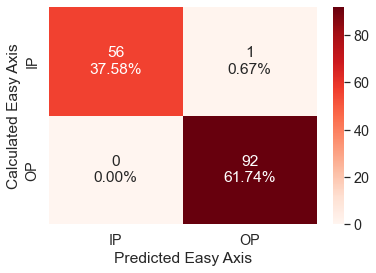

In [157]:
sns.set(font_scale=1.3)
confusion_mat(train_mat,cmap='Reds',xticklabels=["IP","OP"],yticklabels=["IP","OP"])
plt.xlabel("Predicted Easy Axis")
plt.ylabel("Calculated Easy Axis")
plt.savefig("axis_class_train_confusmat-328.pdf")

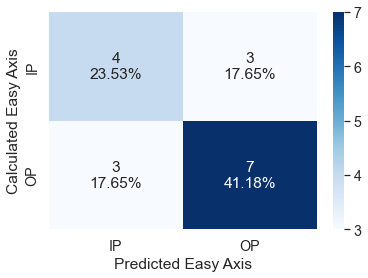

In [159]:
confusion_mat(test_mat,cmap='Blues',xticklabels=["IP","OP"],yticklabels=["IP","OP"])
plt.xlabel("Predicted Easy Axis")
plt.ylabel("Calculated Easy Axis")
plt.savefig("axis_class_valid_confusmat-328.pdf")

In [167]:
X_val_star_sets=[]
X_train_star_sets=[]

for xt,xv in zip(X_train_sets,X_val_sets):
    X_val_star_sets.append(xv[list(X_tr_try.columns)])
    X_train_star_sets.append(xt[list(X_tr_try.columns)])


0


<Figure size 640x480 with 0 Axes>

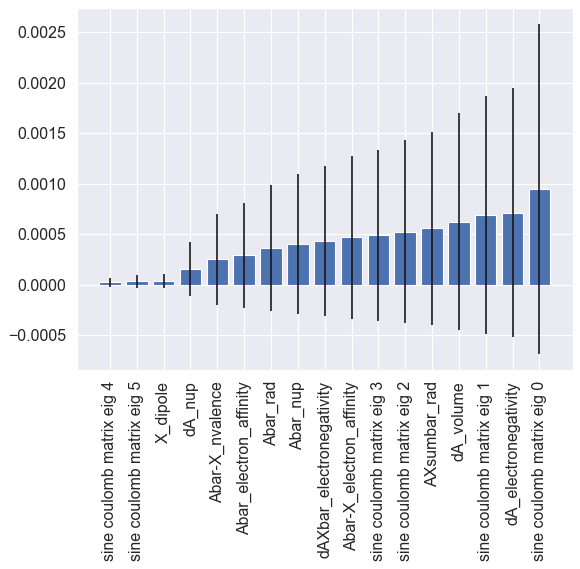

<Figure size 640x480 with 0 Axes>

In [169]:
plt.figure(figsize=(8, 6), dpi=80)
calc_importances(RandomForestClassifier,X_train_star_sets,y_train_sets,model_params=best_params4)
plt.xticks(rotation=90)
plt.savefig("axis_class_import-328.pdf")
plt.figure(figsize=(8, 6), dpi=80)

In [34]:
y_val

75     1
132    1
47     1
115   -1
66    -1
54     1
85     1
167    1
14     1
70    -1
131    1
49     1
107   -1
81     1
73    -1
92    -1
169    1
Name: sign_MA, dtype: int64

In [40]:
clf_star,_,_,_,_=train_and_eval_classifier(RandomForestClassifier,X_tr_star,y_train,X_val_star,y_val,model_params=best_params)

test
train confusion matrix: [[58  0]
 [ 0 91]]
train f1-score: 1.0
test confusion matrix: [[3 3]
 [3 8]]
test f1-score: 0.6136363636363636


In [43]:
import sklearn.metrics as sk_metrics
import random

y_pred_allpos=[1 for _ in y_val]
y_pred_allneg=[-1 for _ in y_val]
y_pred_rands=[[random.choice([-1,1]) for _ in y_val] for i in range(0,1000)]
f1_scores=[sk_metrics.f1_score(y_val,y_p,average='macro') for y_p in y_pred_rands]
auc_scores=[sk_metrics.roc_auc_score(y_val,y_p,average='macro') for y_p in y_pred_rands]
rand_f1_mean=np.mean(f1_scores)
rand_f1_std=np.std(f1_scores)
rand_auc_mean=np.mean(auc_scores)
rand_auc_std=np.std(auc_scores)

print(f"all positive produces a f1 macro score of {sk_metrics.f1_score(y_val,y_pred_allpos,average='macro')}")
print(f"all neg produces a f1 macro score of {sk_metrics.f1_score(y_val,y_pred_allneg,average='macro')}")
print(f"random produces an average f1 macro score of {rand_f1_mean} and an std of {rand_f1_std}")
print('\n')
print(f"all positive produces a auc macro score of {sk_metrics.roc_auc_score(y_val,y_pred_allpos,average='macro')}")
print(f"all neg produces a auc macro score of {sk_metrics.roc_auc_score(y_val,y_pred_allneg,average='macro')}")
print(f"random produces an average auc macro score of {rand_auc_mean} and an std of {rand_auc_std}")


all positive produces a f1 macro score of 0.3928571428571429
all neg produces a f1 macro score of 0.2608695652173913
random produces an average f1 macro score of 0.4845848790607547 and an std of 0.12459904399704891


all positive produces a auc macro score of 0.5
all neg produces a auc macro score of 0.5
random produces an average auc macro score of 0.5026742424242425 and an std of 0.12954642720705203


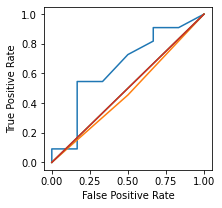

In [67]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve,roc_auc_score

plt.figure(figsize=(3,3))

ax=plt.gca()
#RocCurveDisplay.from_estimator()
#RocCurveDisplay.from_predictions(y_val,y_valpred,ax=ax,name="Random Forest Classifiear")
RocCurveDisplay.from_estimator(clf_star,X_val_star,y_val,ax=ax,name="Random Forest Classifier")
RocCurveDisplay.from_predictions(y_val,y_pred_rands[209],ax=ax,name="random")
RocCurveDisplay.from_predictions(y_val,y_pred_allpos,ax=ax,name="all positive")
RocCurveDisplay.from_predictions(y_val,y_pred_allneg,ax=ax,name="all negative")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
ax.legend().remove()
plt.savefig("ROC_curve_test.svg",bbox_inches="tight")

Text(0, 0.5, 'True Positive Rate')

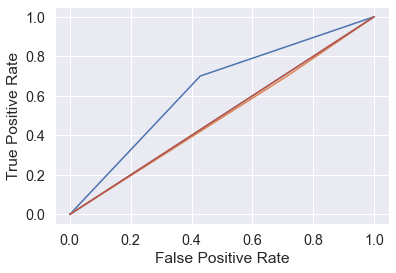

In [175]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve,roc_auc_score

ax=plt.gca()

RocCurveDisplay.from_predictions(y_val,y_valpred,ax=ax,name="Random Forest Classifiear")
#RocCurveDisplay.from_estimator(clf_star,X_val_star,y_val,ax=ax,name="Random Forest Classifier")
RocCurveDisplay.from_predictions(y_val,y_pred_rands[3],ax=ax,name="random")
RocCurveDisplay.from_predictions(y_val,y_pred_allpos,ax=ax,name="all positive")
RocCurveDisplay.from_predictions(y_val,y_pred_allneg,ax=ax,name="all negative")
ax.get_legend().remove()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [17]:
import pickle
with open("axis_classifier-1201.pkl","rb") as f:
    best_drop,best_val_mean,best_val_std,best_tr_mean,best_tr_std,\
col_star,drops_star,all_val_mean,all_val_std,all_tr_mean,all_tr_std,\
best_param_list,grid_clf_list,grid_df_list,t_star=pickle.load(f)

In [18]:
col_star

['Abar_rad',
 'dA_volume',
 'dA_nup',
 'dA_electronegativity',
 'X_dipole',
 'Abar-X_electron_affinity',
 'Abar_electron_affinity',
 'Abar_nup',
 'Abar-X_nvalence']

In [84]:
y_val=22*[-1]+19*[+1]
y_valpred=18*[-1]+4*[+1]+10*[-1]+9*[+1]

In [85]:
import sklearn.metrics as sk_metrics
import random

y_pred_allpos=[1 for _ in y_val]
y_pred_allneg=[-1 for _ in y_val]
y_pred_rands=[[random.choice([-1,1]) for _ in y_val] for i in range(0,1000)]
f1_scores=[sk_metrics.f1_score(y_val,y_p,average='macro') for y_p in y_pred_rands]
auc_scores=[sk_metrics.roc_auc_score(y_val,y_p,average='macro') for y_p in y_pred_rands]
rand_f1_mean=np.mean(f1_scores)
rand_f1_std=np.std(f1_scores)
rand_auc_mean=np.mean(auc_scores)
rand_auc_std=np.std(auc_scores)

print(f"all positive produces a f1 macro score of {sk_metrics.f1_score(y_val,y_pred_allpos,average='macro')}")
print(f"all neg produces a f1 macro score of {sk_metrics.f1_score(y_val,y_pred_allneg,average='macro')}")
print(f"random produces an average f1 macro score of {rand_f1_mean} and an std of {rand_f1_std}")
print('\n')
print(f"all positive produces a auc macro score of {sk_metrics.roc_auc_score(y_val,y_pred_allpos,average='macro')}")
print(f"all neg produces a auc macro score of {sk_metrics.roc_auc_score(y_val,y_pred_allneg,average='macro')}")
print(f"random produces an average auc macro score of {rand_auc_mean} and an std of {rand_auc_std}")


all positive produces a f1 macro score of 0.3166666666666667
all neg produces a f1 macro score of 0.34920634920634924
random produces an average f1 macro score of 0.49636032226215243 and an std of 0.07853394955310058


all positive produces a auc macro score of 0.5
all neg produces a auc macro score of 0.5
random produces an average auc macro score of 0.5000406698564593 and an std of 0.07817103106053658


Text(0, 0.5, 'True Positive Rate')

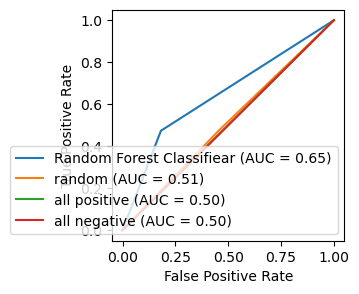

In [90]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve,roc_auc_score

plt.figure(figsize=(3,3))

ax=plt.gca()

RocCurveDisplay.from_predictions(y_val,y_valpred,ax=ax,name="Random Forest Classifiear")
#RocCurveDisplay.from_estimator(clf_star,X_val_star,y_val,ax=ax,name="Random Forest Classifier")
RocCurveDisplay.from_predictions(y_val,y_pred_rands[0],ax=ax,name="random")
RocCurveDisplay.from_predictions(y_val,y_pred_allpos,ax=ax,name="all positive")
RocCurveDisplay.from_predictions(y_val,y_pred_allneg,ax=ax,name="all negative")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# leg=plt.legend()
# leg.remove()